In [1]:
import os
import re
import sys
sys.path.append('../')
import json
import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transform import TimeSeriesTransform

In [2]:
cfg = json.load(open("../config/config.json"))

ts_trans = TimeSeriesTransform(cfg)

In [3]:
INSTANCES_DIR = '../data/linear_acuator/instances/'
INFERENCE_DIR = '../data/linear_acuator/inference/'
STATES = ['normal', 
            'backlash1', 'backlash2',
            'lackLubrication1', 'lackLubrication2',
            'spalling1', 'spalling2', 'spalling3', 'spalling4', 'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']

In [4]:
load = '20kg'
filenames = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames = [filename for sublist in filenames for filename in sublist]

In [5]:
X, y = [], []
for filename in filenames:
    load_num = load[:2]
    state = re.match(fr'(.*)_{load_num}', filename).group(1)
    df = pd.read_csv(os.path.join(INSTANCES_DIR, load, state, filename))
    tmp_cur = ts_trans.smoothing(ts_df=df, field='current')
    # tmp_pos = ts_transform.smoothing(ts_df=df, field='position_error')
    X.append(tmp_cur)
    y.append(state)

In [30]:
first_ts = X[0]
# Define scales and perform Continuous Wavelet Transform (CWT)
wavelet = 'morl'  # Morlet wavelet for CWT
scales = np.arange(1, 1001)  # Range of scales to use for the CWT
coefficients, frequencies = pywt.cwt(first_ts, scales, wavelet, sampling_period=1/400)

In [31]:
coefficients.shape

(1000, 324)

25.973836466461382


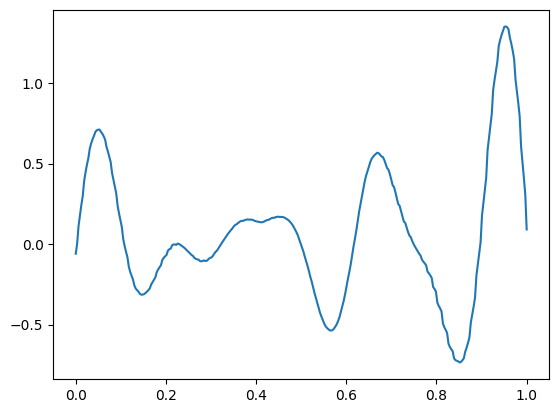

In [32]:
from scipy.integrate import simpson

selected_func = coefficients[50]
integral_simps = simpson(selected_func)
print(integral_simps)

plt.plot(np.linspace(0, 1, len(first_ts)), selected_func)
plt.show()

In [35]:
vector =[]
for coff in coefficients:
    integral_simps = simpson(coff)
    vector.append(integral_simps)
vector = np.array(vector)
print(vector)
print(vector.shape)

[-1.30305316e-01  5.69651144e-02  3.85059008e-02  2.76338610e-01
  5.55121693e-01  7.72838922e-01  9.56497362e-01  1.31830085e+00
  1.58828067e+00  2.10467929e+00  2.63493515e+00  3.11596164e+00
  3.79728960e+00  4.31558131e+00  4.87471477e+00  5.43987472e+00
  6.06698041e+00  6.63405869e+00  7.07754049e+00  7.62375036e+00
  7.86849682e+00  8.65660132e+00  9.06245367e+00  9.52870336e+00
  1.01158341e+01  1.03083756e+01  1.08956129e+01  1.13826506e+01
  1.19561612e+01  1.24626710e+01  1.27570511e+01  1.33913507e+01
  1.40607991e+01  1.46281385e+01  1.50771657e+01  1.55484149e+01
  1.62266768e+01  1.67977357e+01  1.74067984e+01  1.82207104e+01
  1.88109296e+01  1.98995834e+01  1.97594580e+01  2.05867593e+01
  2.13510924e+01  2.21151907e+01  2.28471141e+01  2.34843108e+01
  2.44174745e+01  2.51066954e+01  2.59738365e+01  2.68023238e+01
  2.76144254e+01  2.86107068e+01  2.95361648e+01  3.04204123e+01
  3.14600875e+01  3.27411229e+01  3.38153218e+01  3.49159591e+01
  3.59703460e+01  3.68449

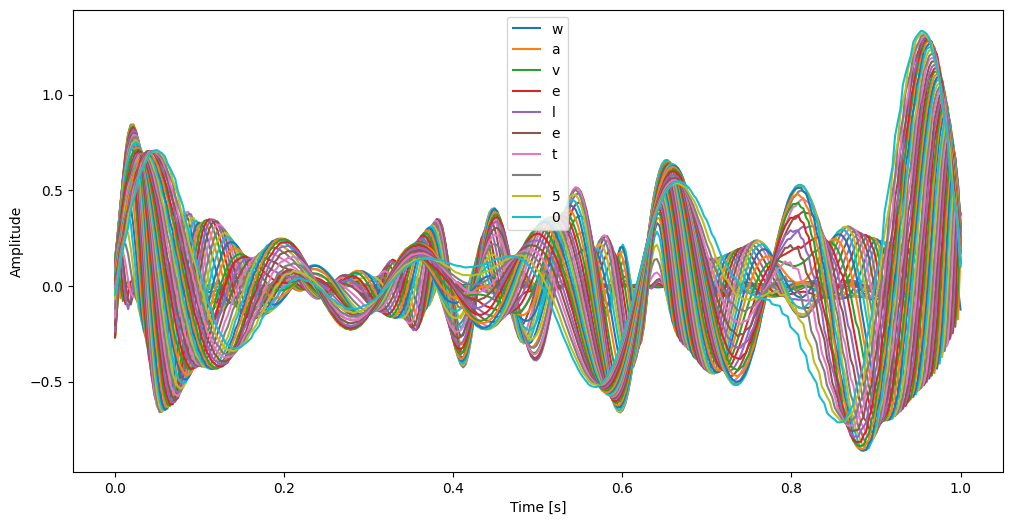

In [33]:
plt.figure(figsize=(12, 6))
for i in range(50):
    plt.plot(np.linspace(0, 1, len(first_ts)), np.real(coefficients[i]))
    # plt.title(f'Morlet Wavelet (f_c={f_c:.2f} Hz, sigma={sigma:.2f})')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend(f"wavelet {i+1}")
plt.show()

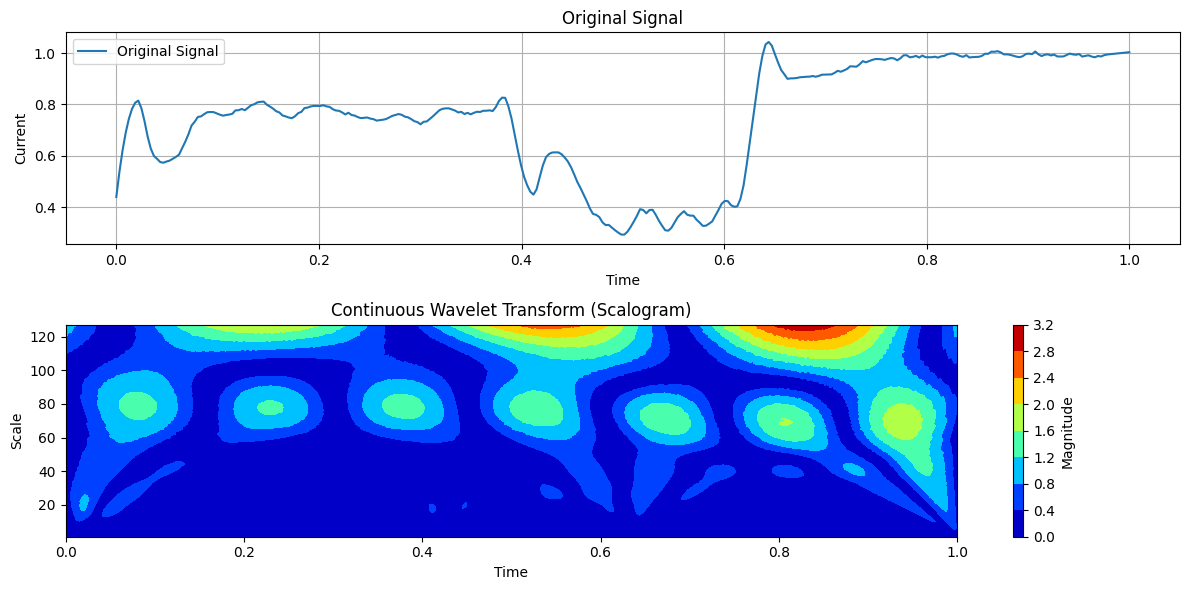

In [7]:
# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, 1, len(first_ts)), first_ts, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Current')
plt.grid(True)
plt.legend()

# Plot the 2D CWT scalogram
plt.subplot(2, 1, 2)
plt.contourf(np.linspace(0, 1, len(first_ts)), scales, np.abs(coefficients), cmap='jet')
plt.title('Continuous Wavelet Transform (Scalogram)')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

In [29]:
all_instances = {str(load) + '_' + str(state): os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES for load in LOADS}

In [30]:
average_dict = {}
for k, v in all_instances.items():    
    load, state = k.split('_')
    # Average all current and position error of 20kgnormal
    if load == '20kg':
        all_files = all_instances[k]
        average_dict[k] = {'current': [], 'position_error': []}

        n_cur = len(pd.read_csv(os.path.join(INSTANCES_DIR, load, state, all_files[0]))['current'])
        n_pos_err = len(pd.read_csv(os.path.join(INSTANCES_DIR, load, state, all_files[0]))['position_error'])

        average_df = {'current': [0] * n_cur, 'position_error': [0] * n_pos_err}

        for filename in all_files:
            df = pd.read_csv(os.path.join(INSTANCES_DIR, load, state, filename))
            average_df['current'] += df['current']
            average_df['position_error'] += df['position_error']

        average_df['current'] = average_df['current'] / len(all_files)
        average_df['position_error'] = average_df['position_error'] / len(all_files)
        
        average_dict[k]['current'] = average_df['current'].tolist()
        average_dict[k]['position_error'] = average_df['position_error'].tolist()

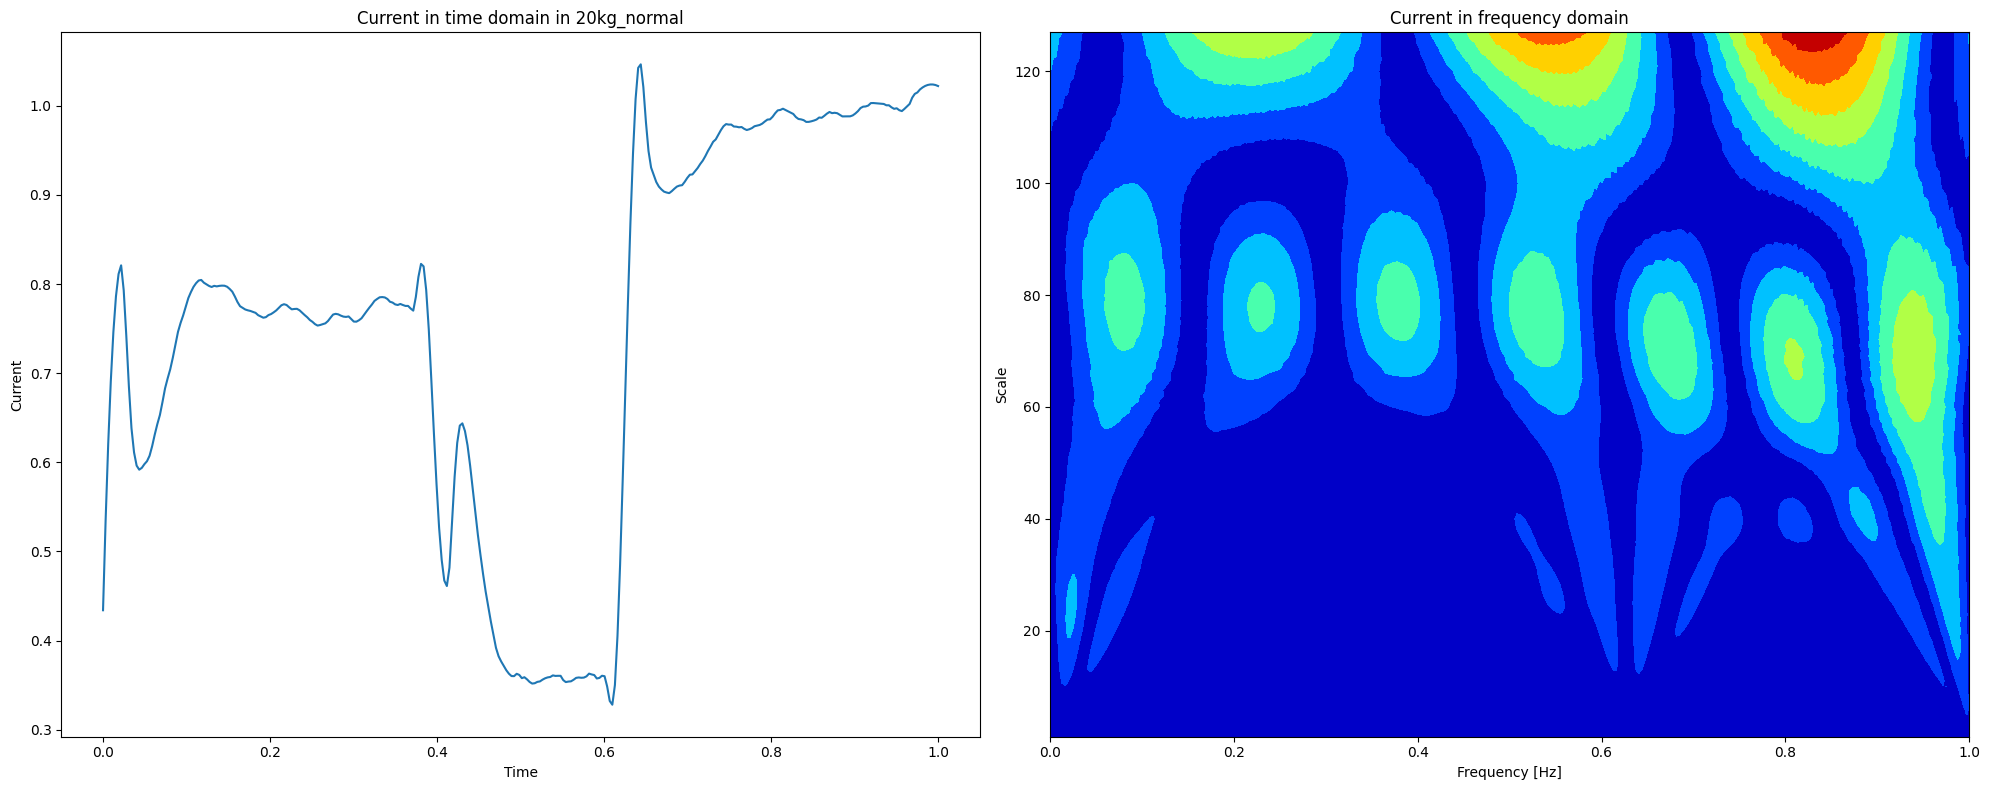

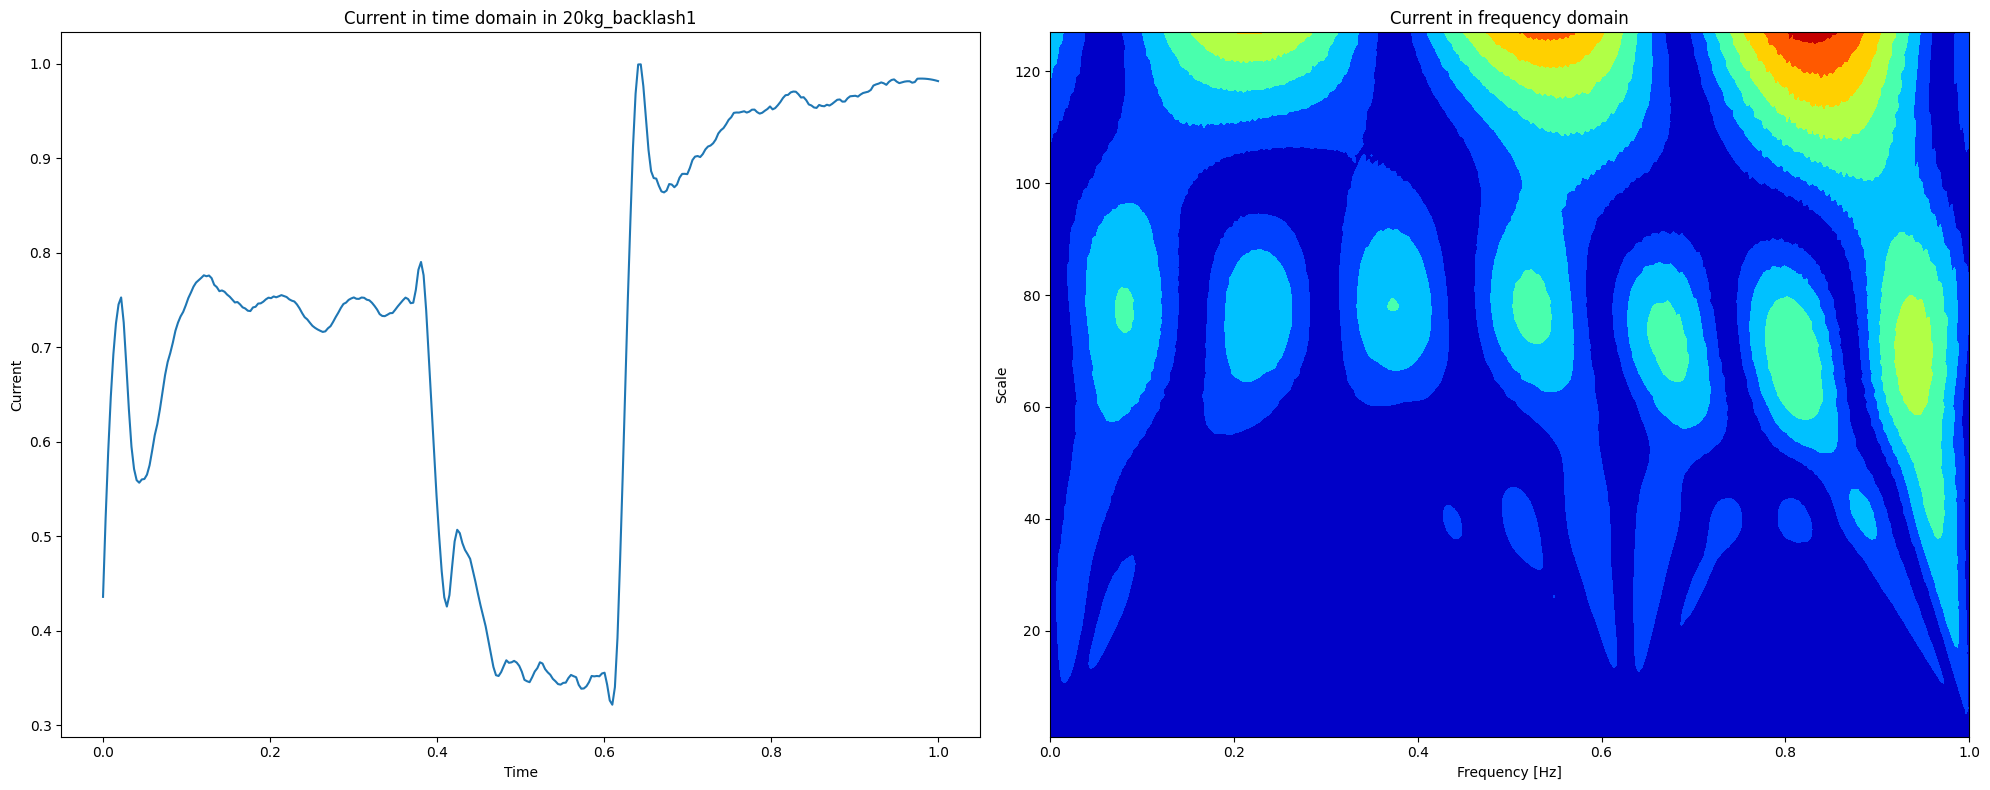

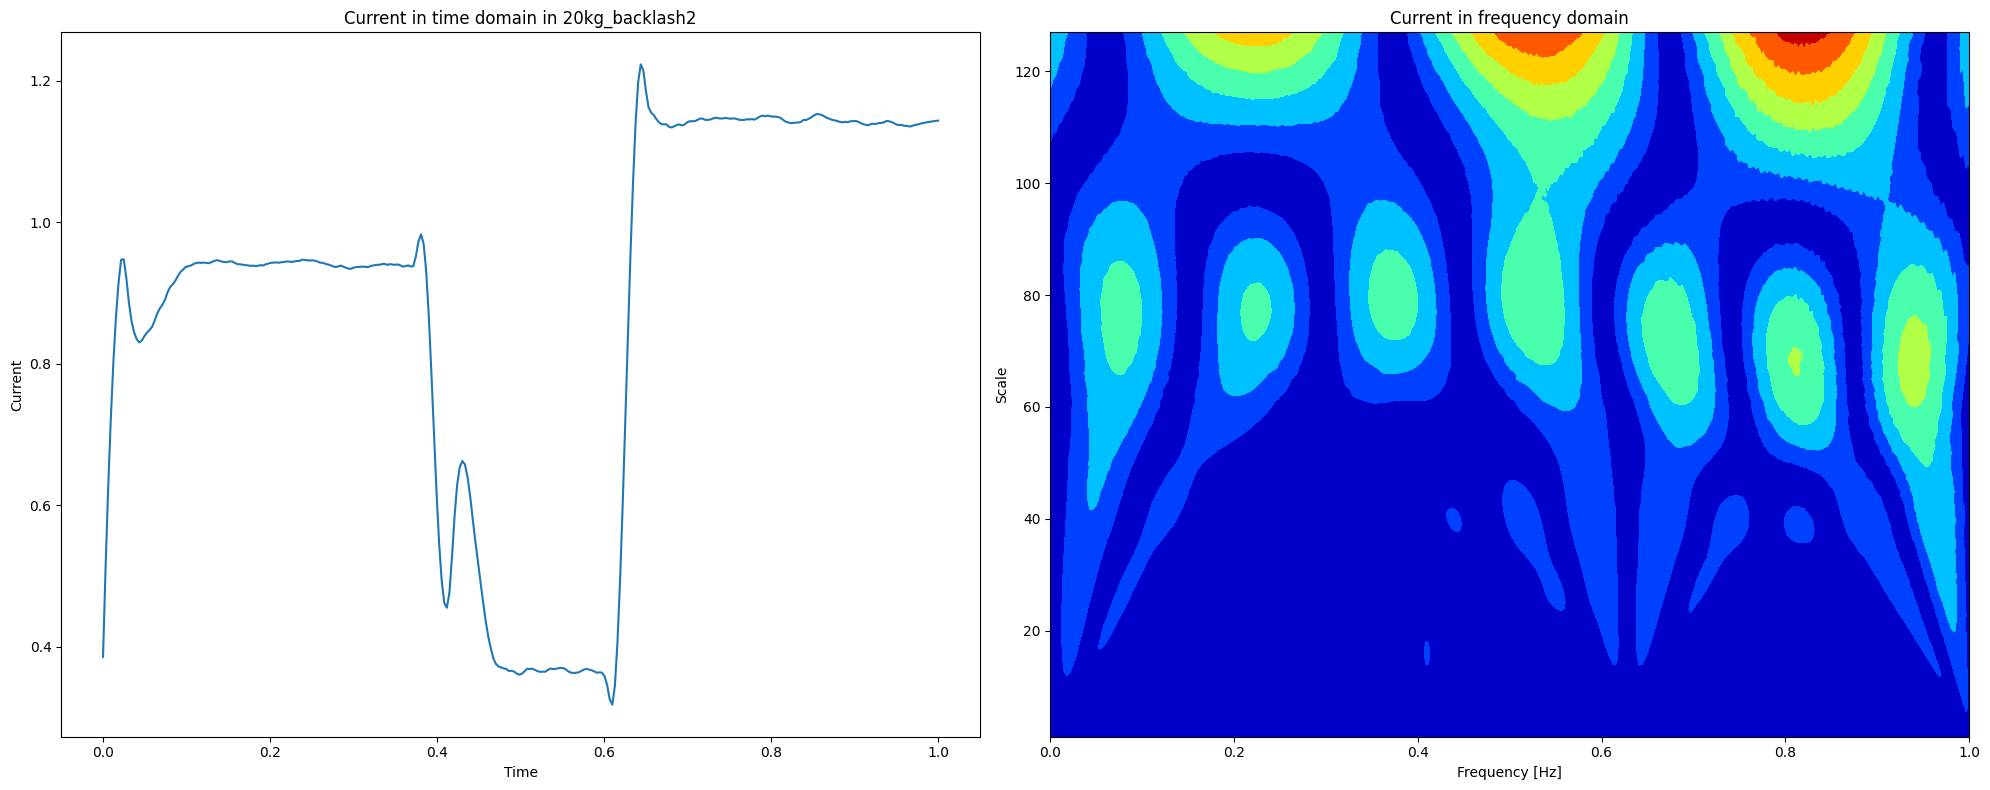

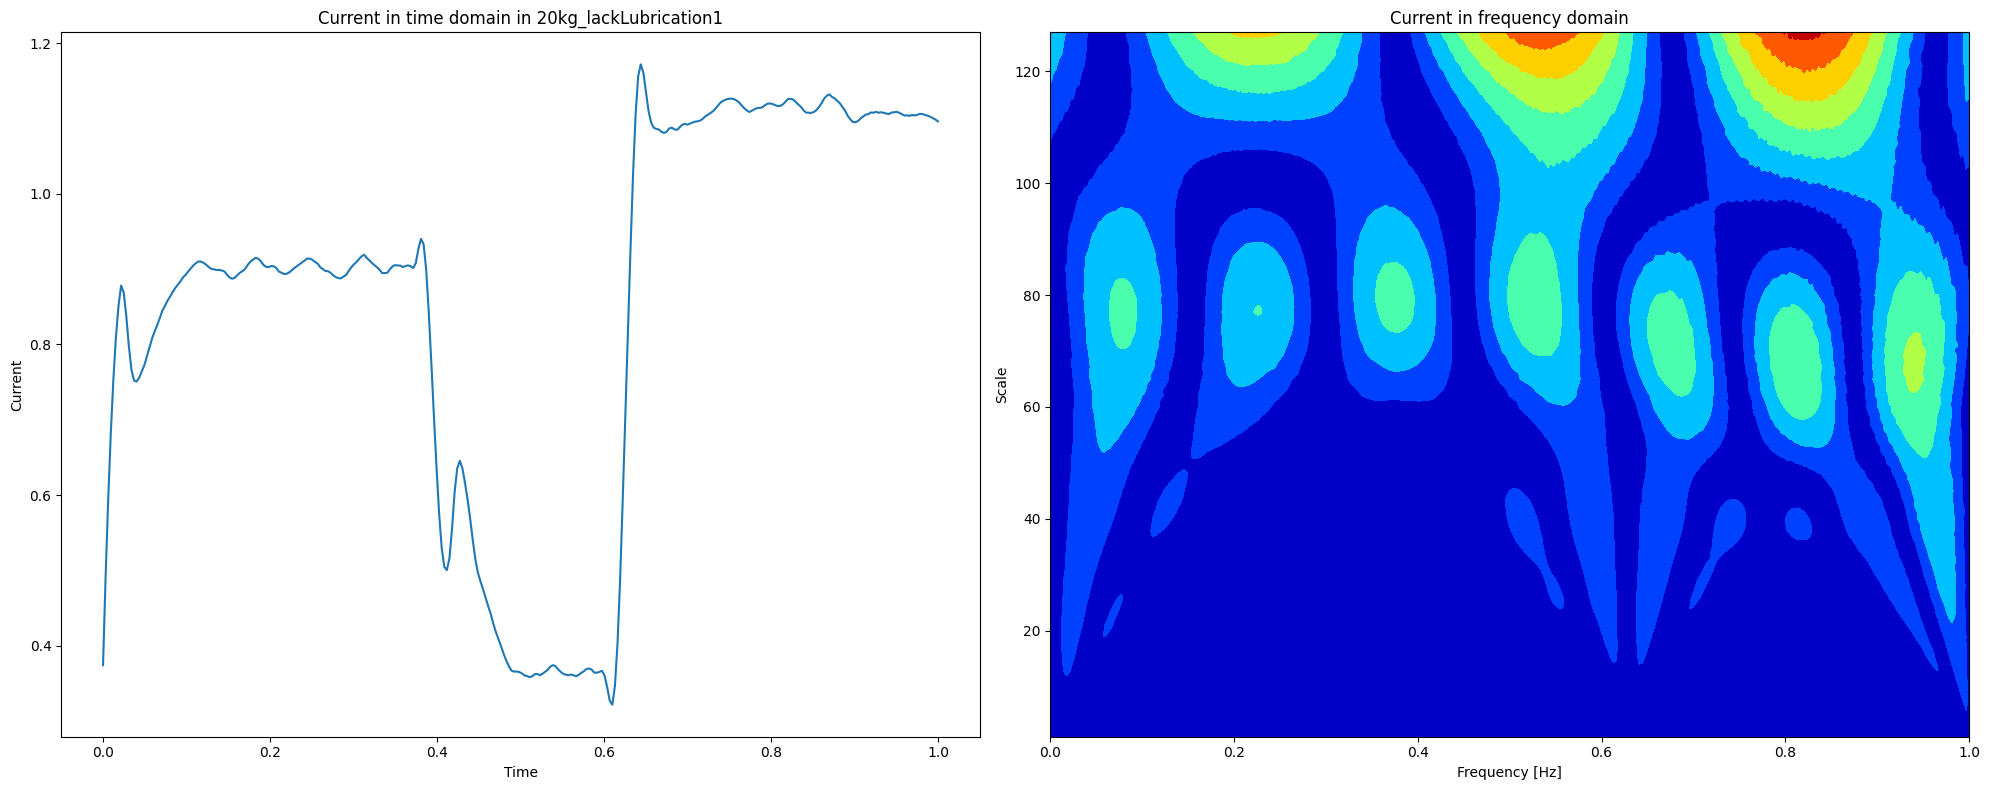

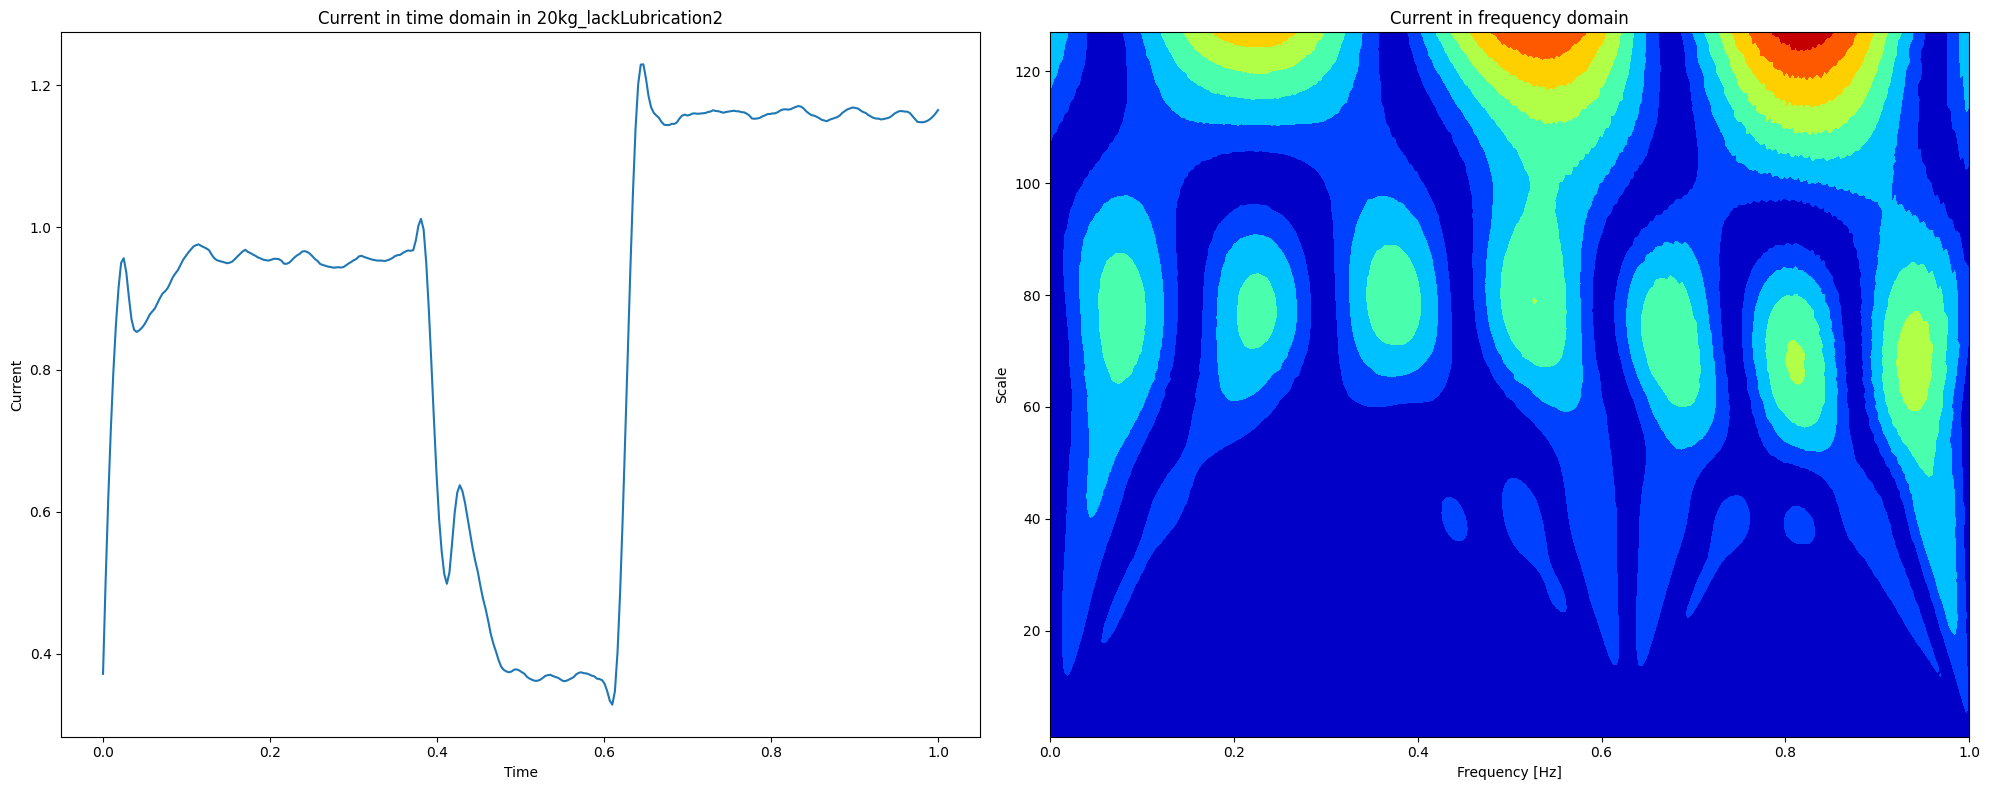

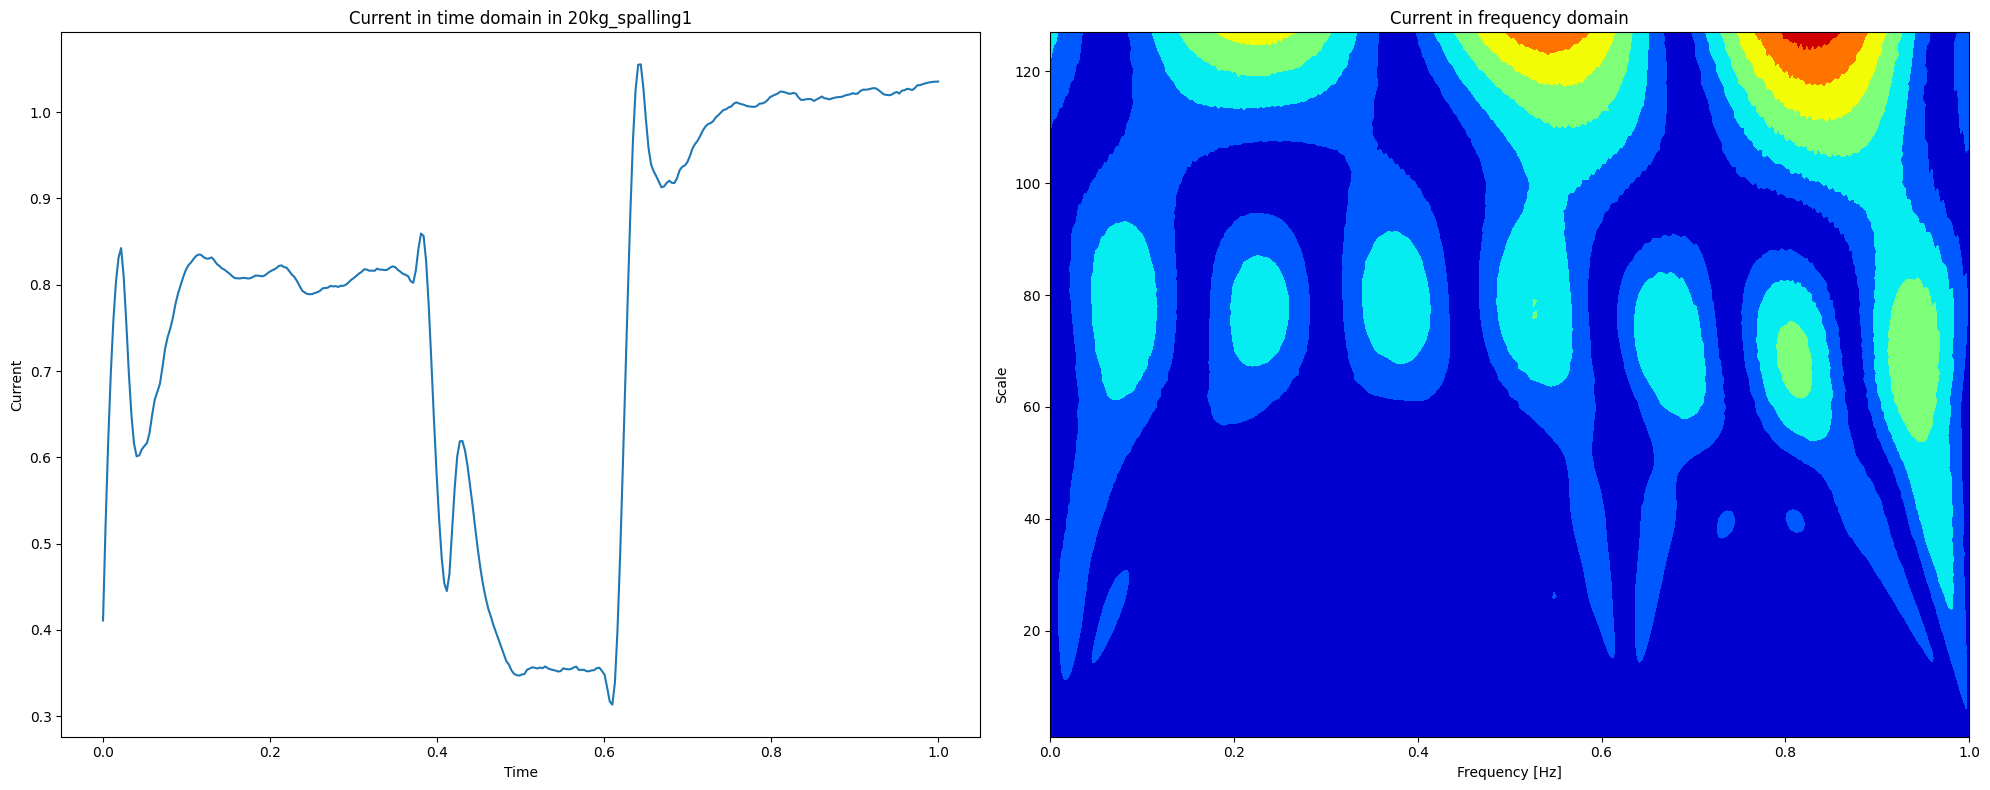

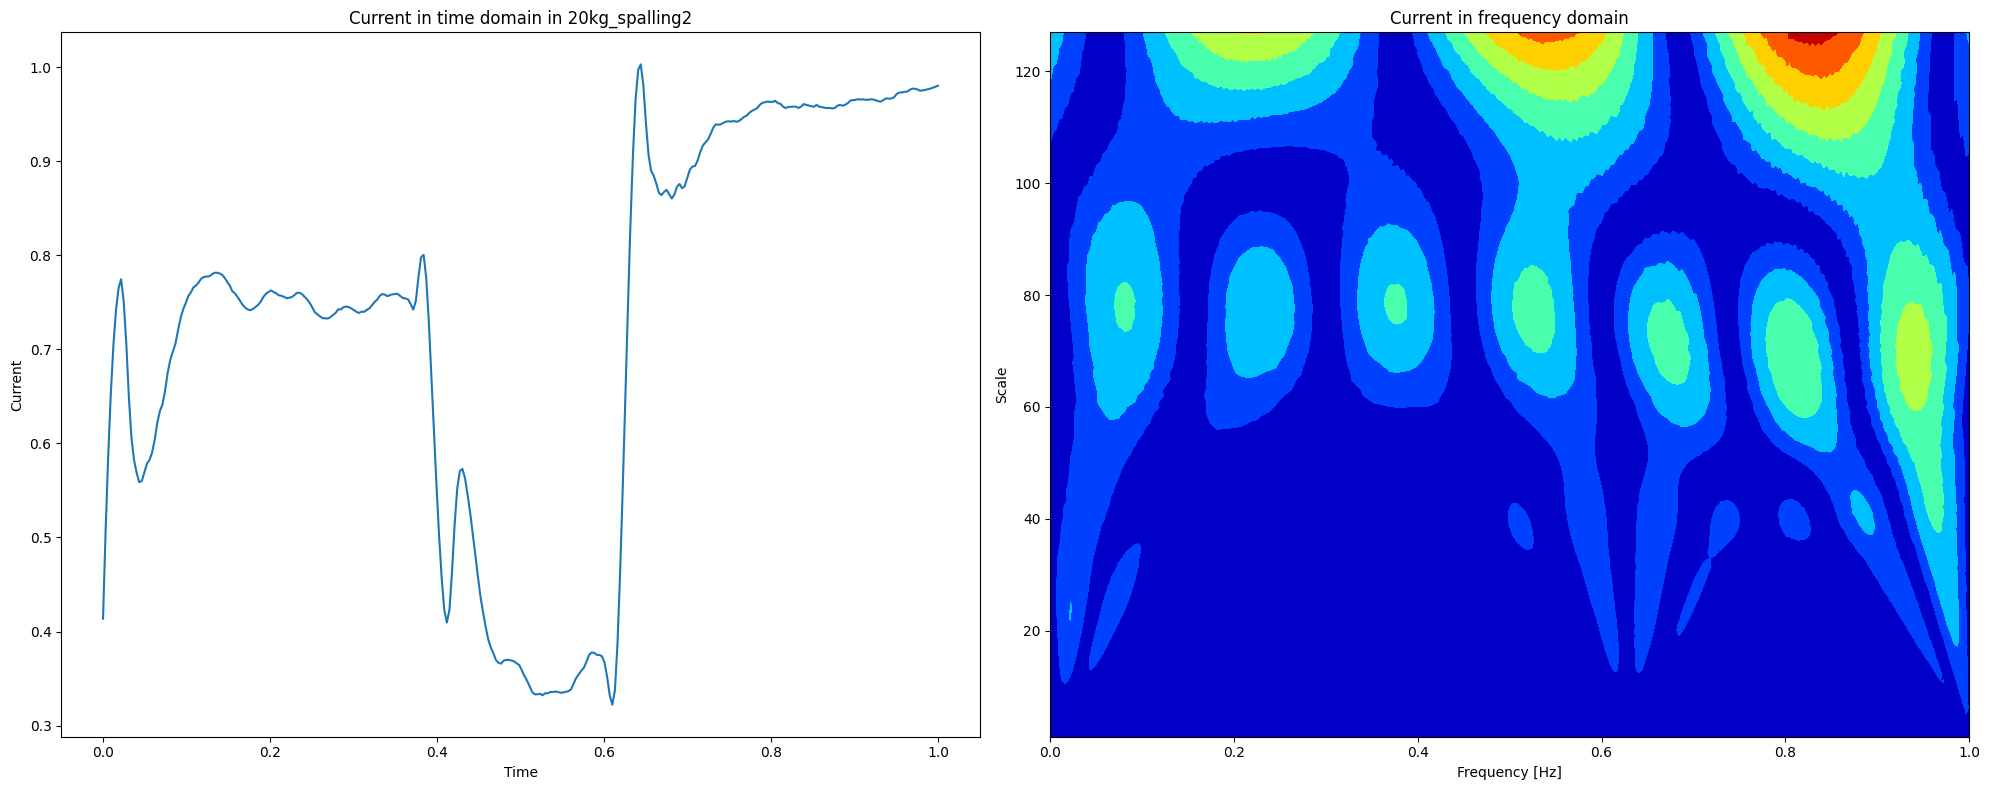

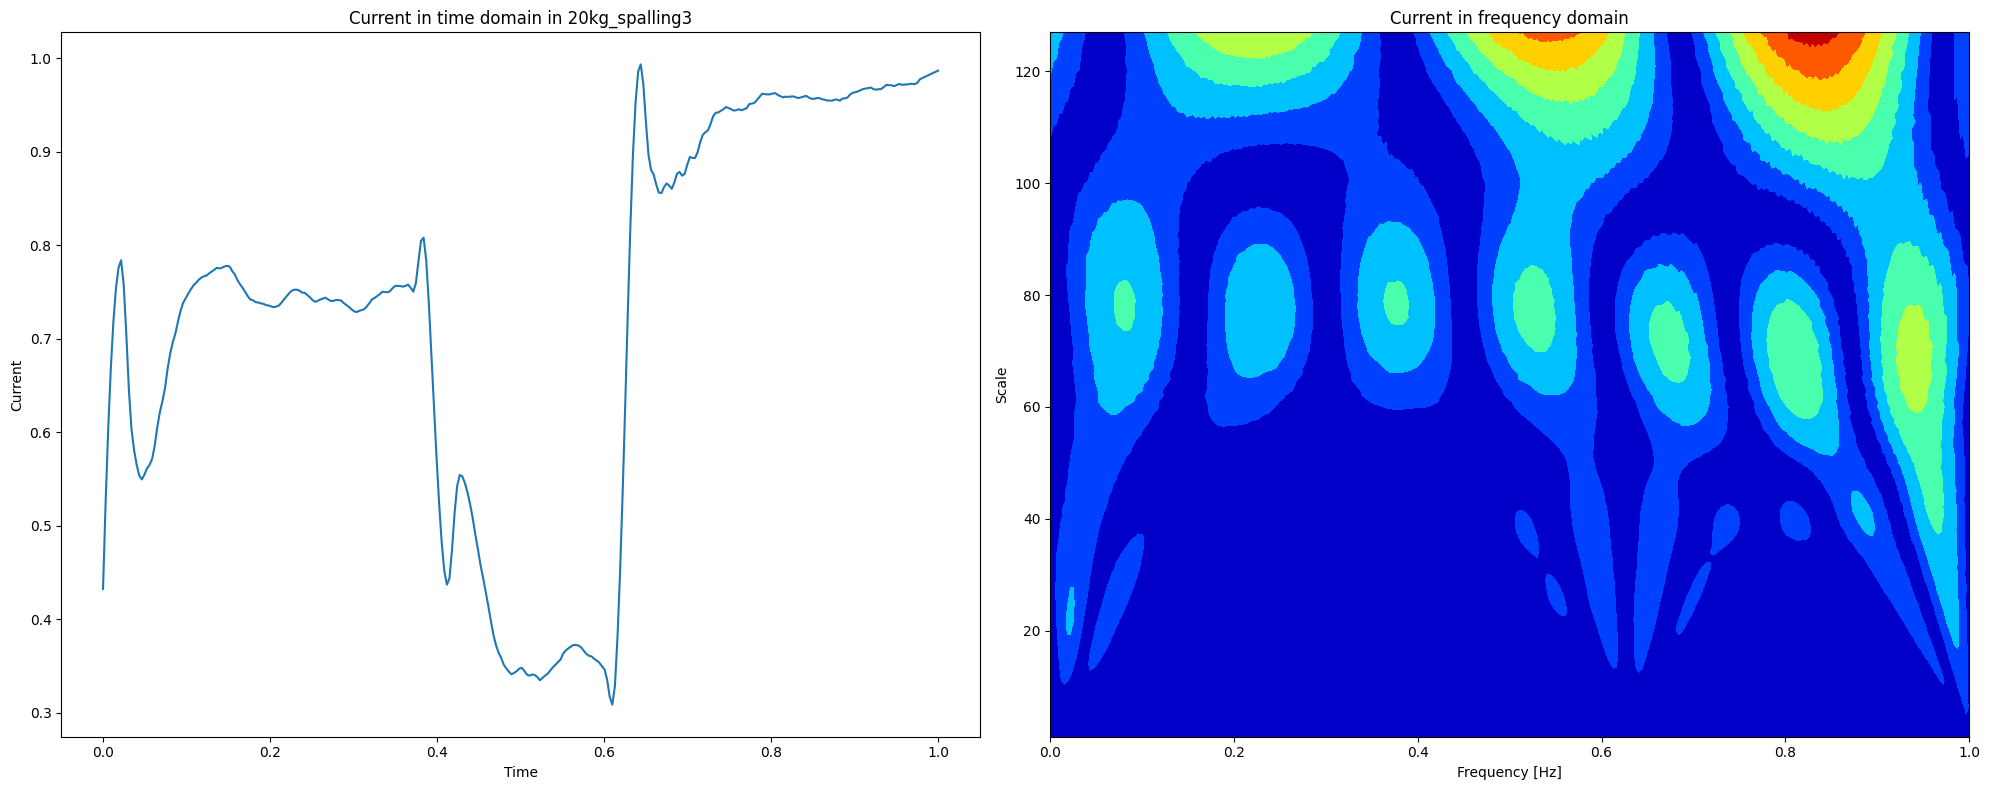

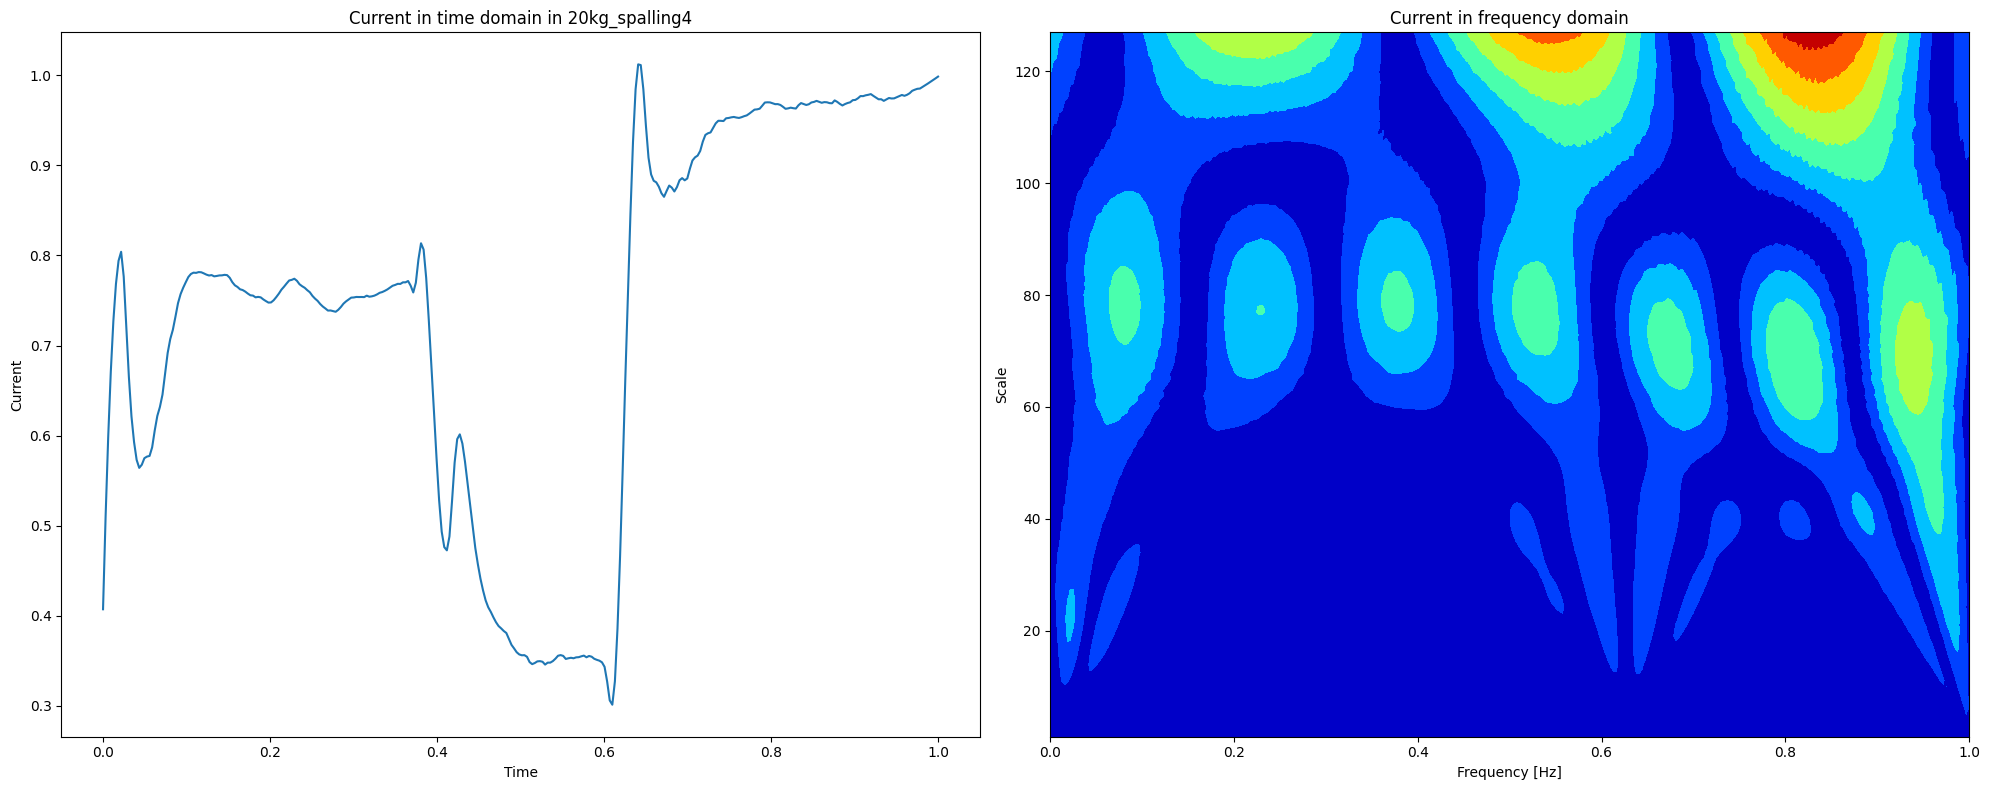

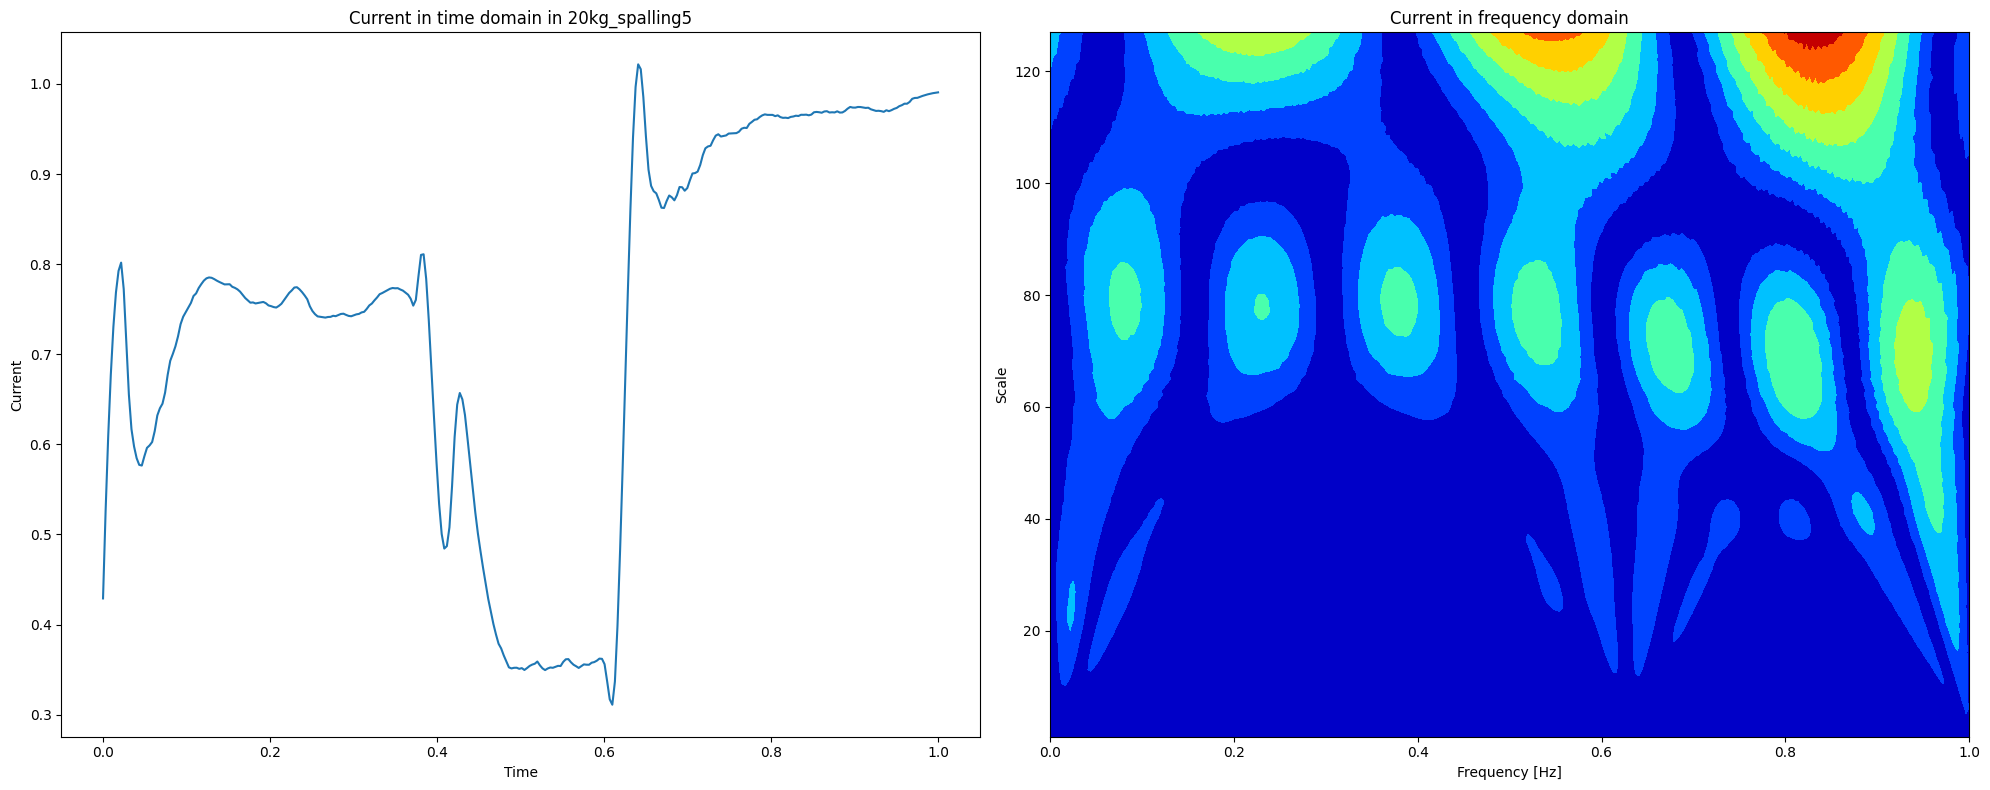

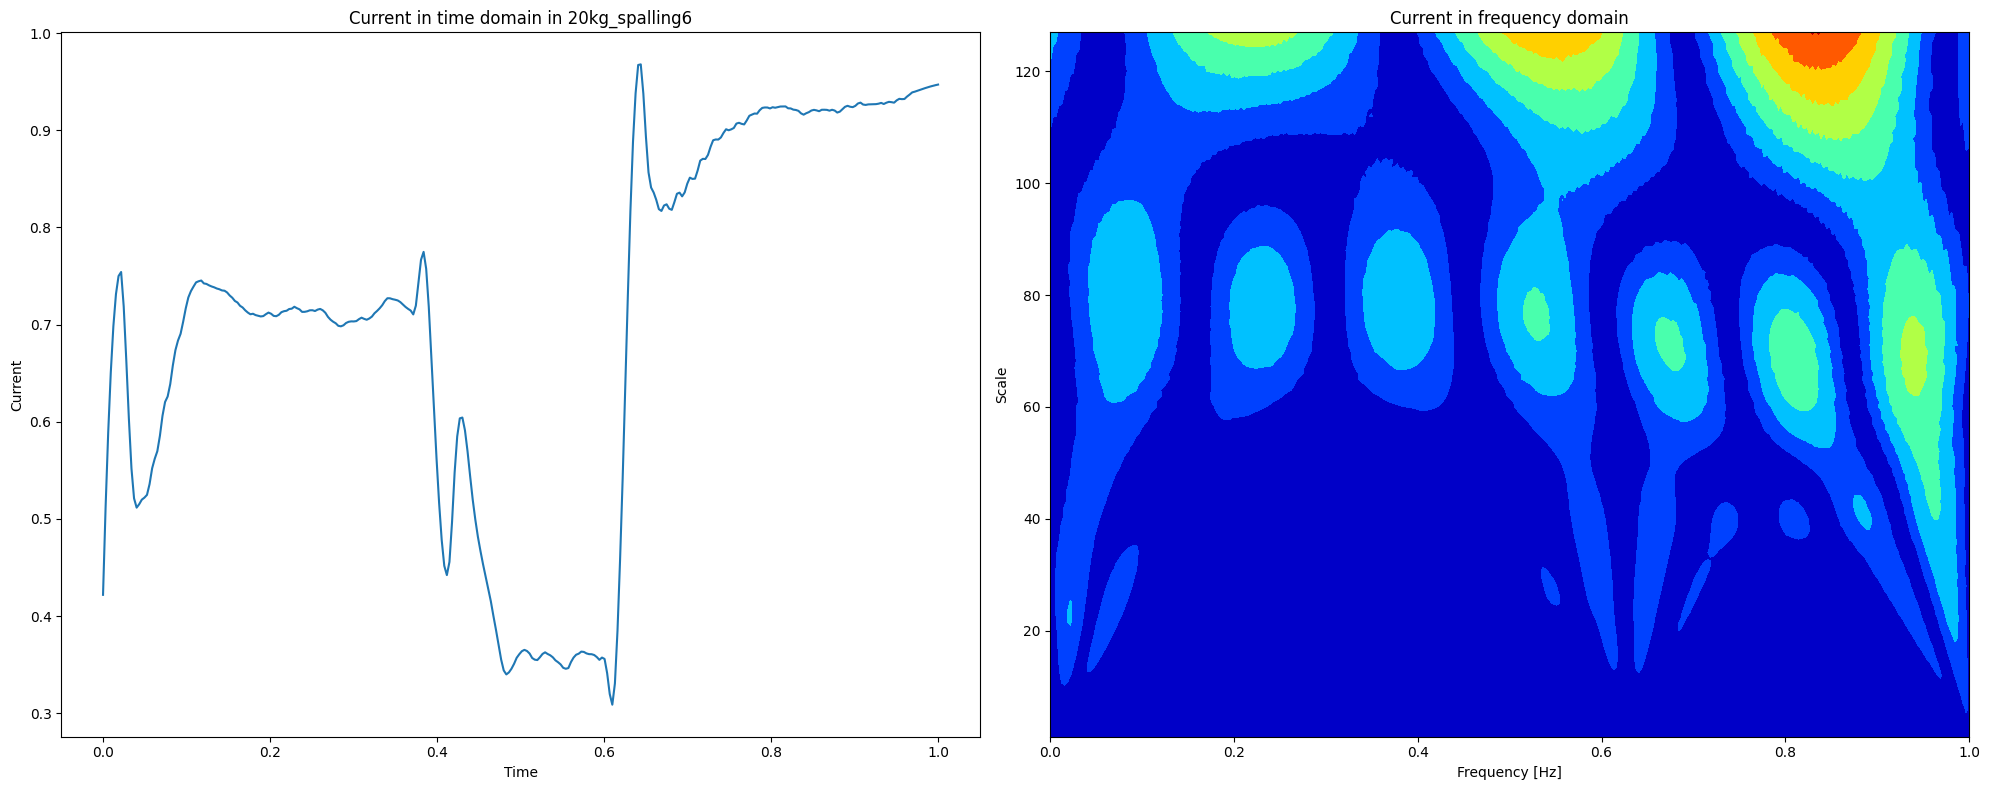

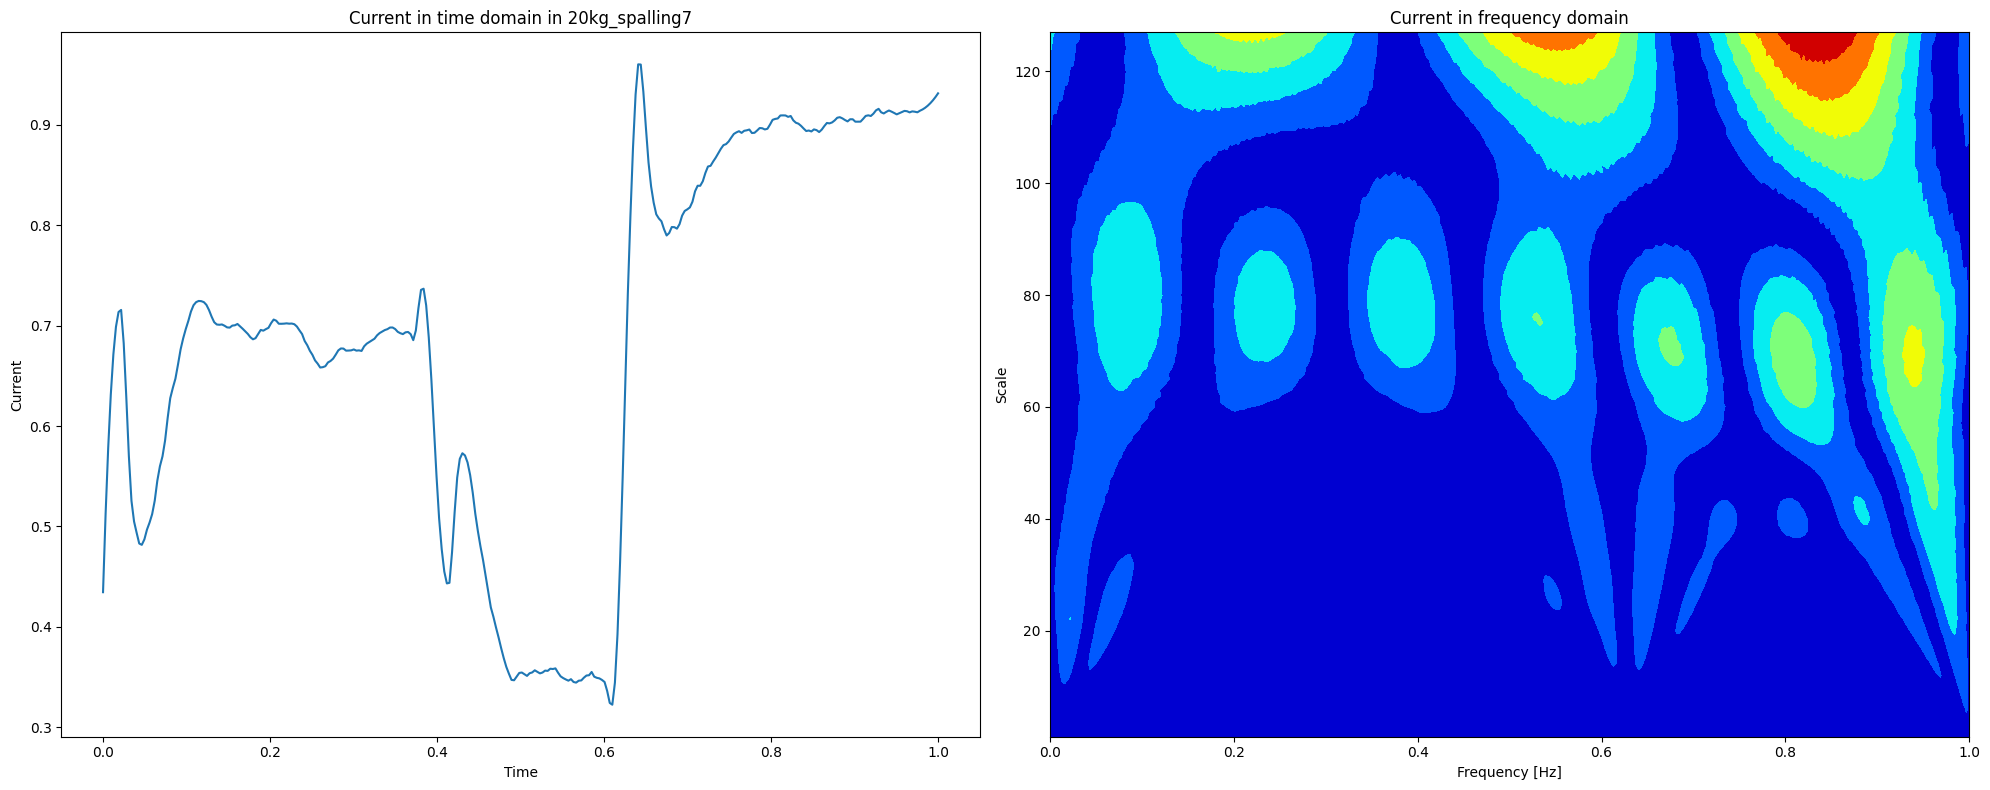

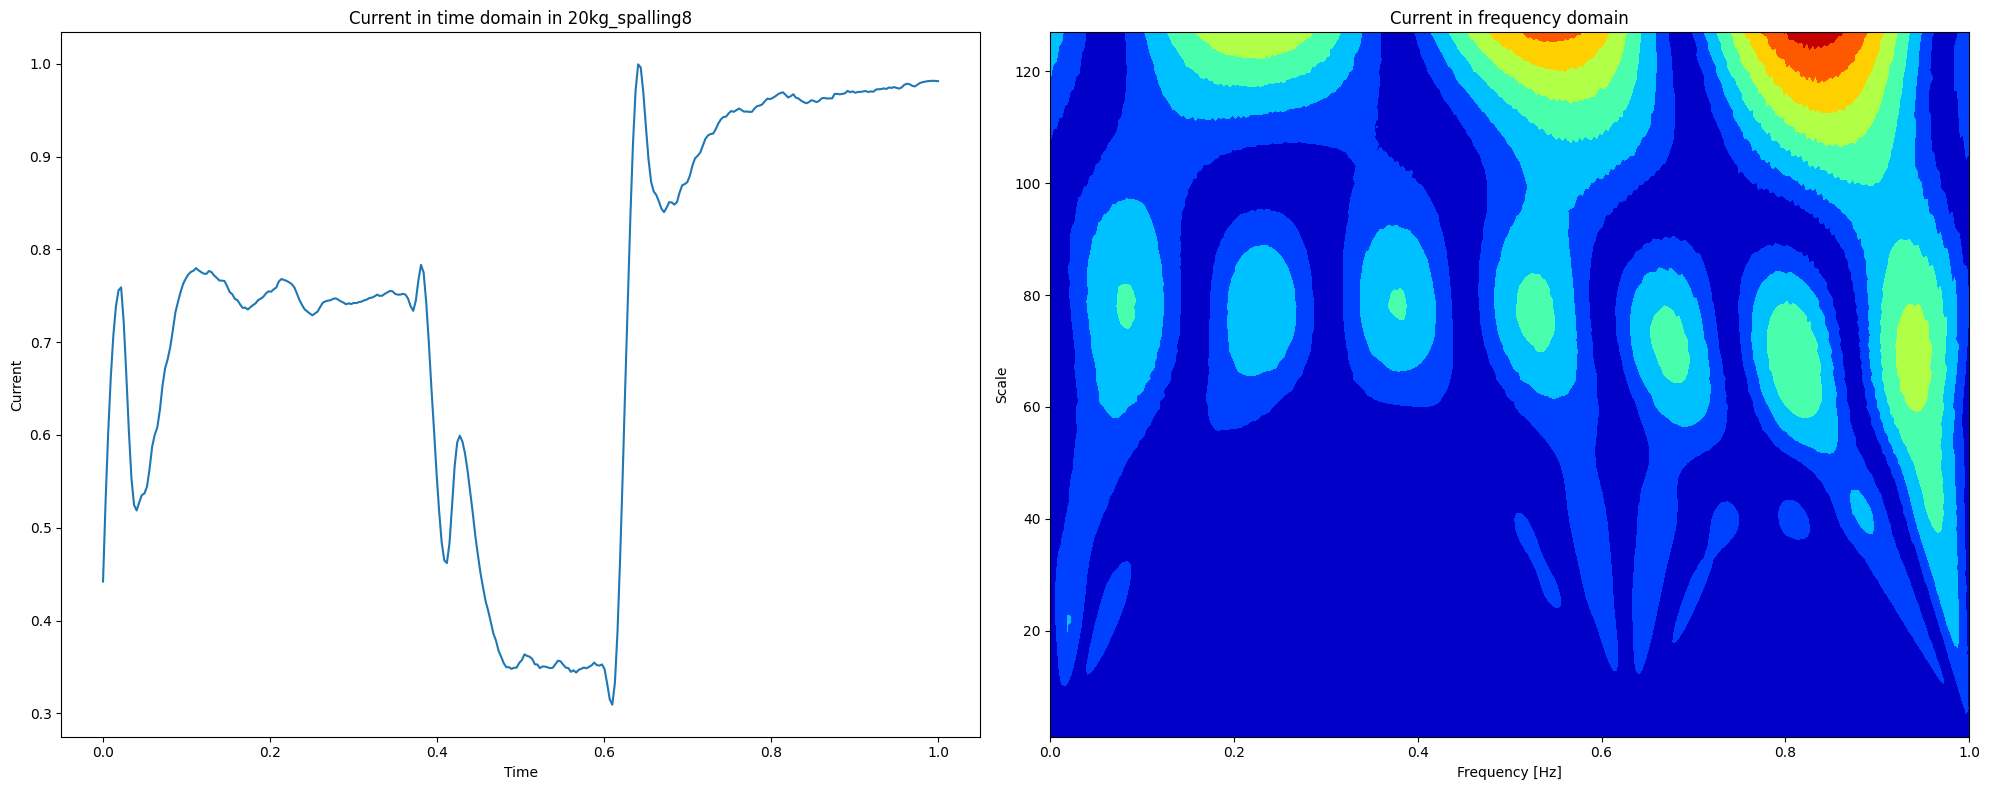

In [52]:
from scipy.signal import savgol_filter


for k, v in average_dict.items():
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    cur = savgol_filter(v['current'], window_length=15, polyorder=2)
    
    # Plot on the first subplot (top-left)
    axs[0].plot(np.linspace(0, 1, len(cur)), cur)
    axs[0].set_title(f'Current in time domain in {k}')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Current')
    # axs[0, 0].legend()

    # Define scales and perform Continuous Wavelet Transform (CWT)
    wavelet = 'morl'  # Morlet wavelet for CWT
    scales = np.arange(1, 128)  # Range of scales to use for the CWT
    coefficients, frequencies = pywt.cwt(cur, scales, wavelet, sampling_period=1/400)
    
    # Plot on the second subplot (top-right)
    axs[1].contourf(np.linspace(0, 1, len(cur)), scales, np.abs(coefficients), cmap='jet')
    axs[1].set_title('Current in frequency domain')
    axs[1].set_xlabel('Frequency [Hz]')
    axs[1].set_ylabel('Scale')
    # fig.colorbar(label='Magnitude')

    # axs[1].legend()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Display the plots
    plt.show()

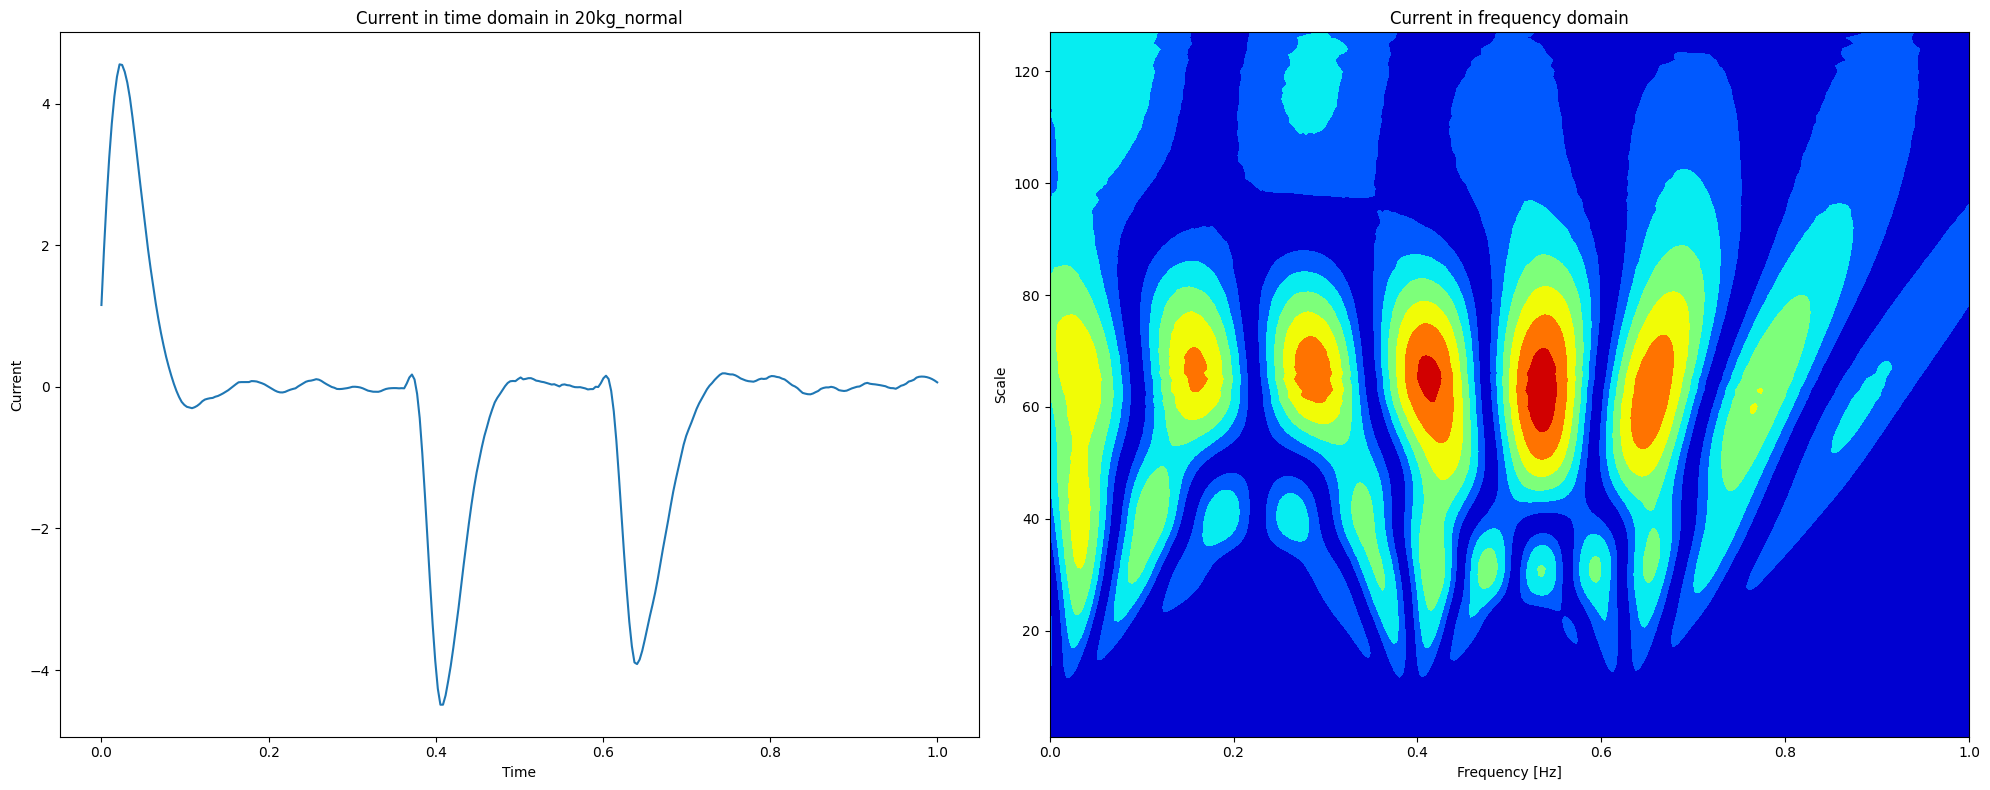

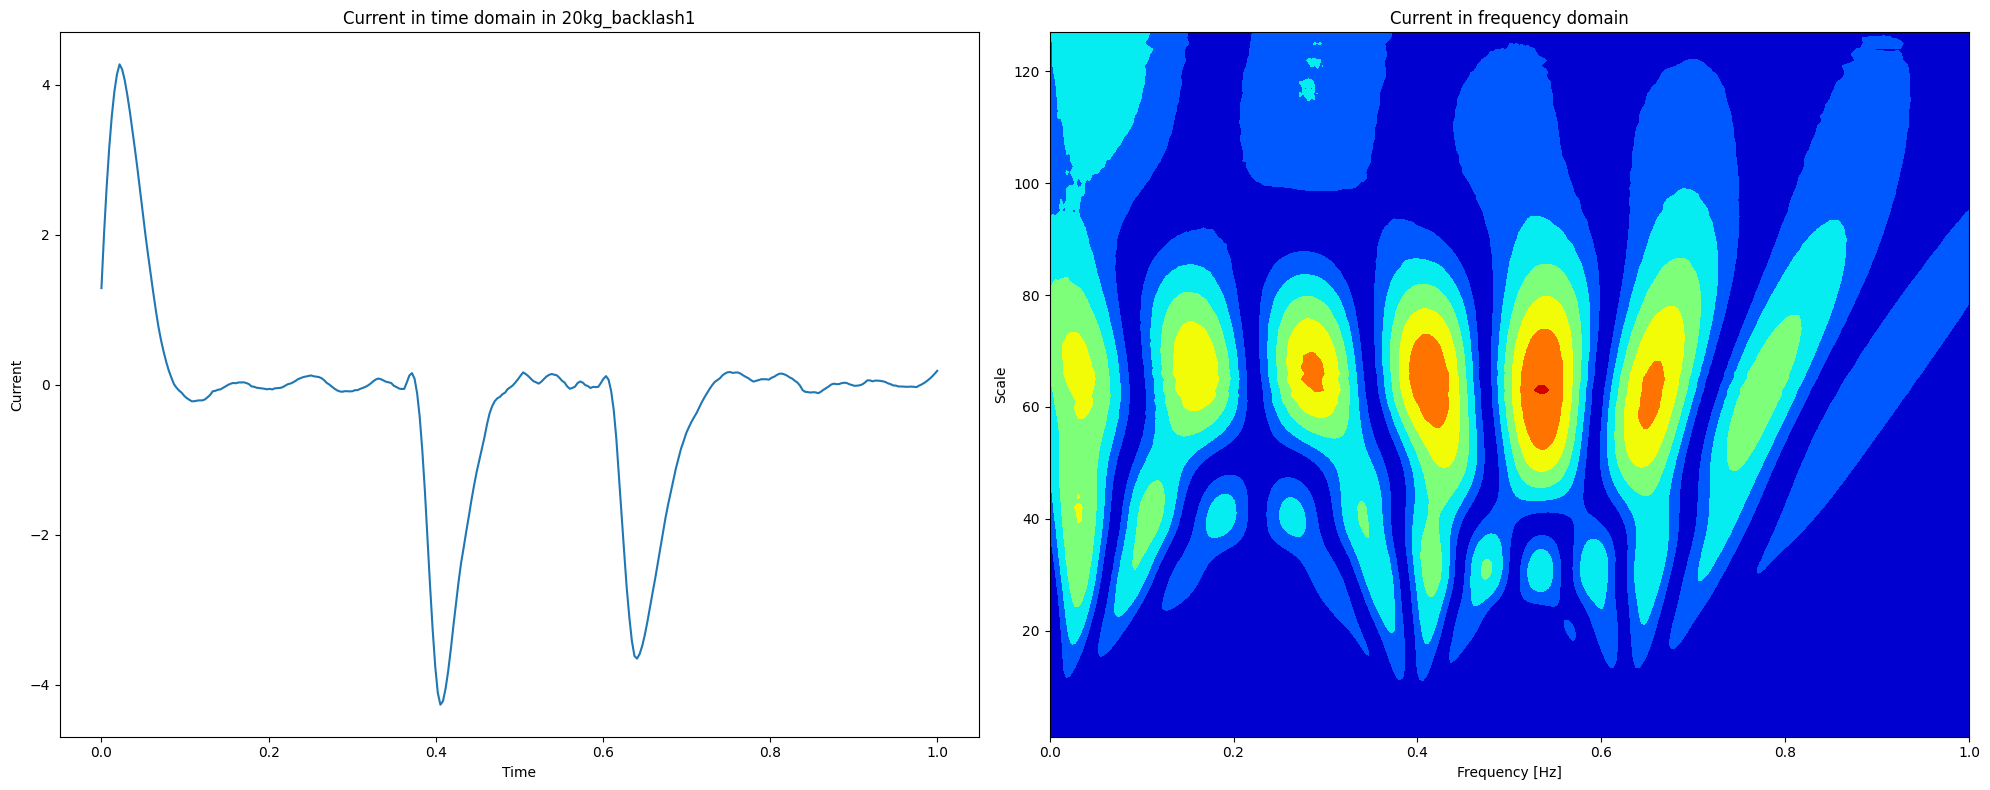

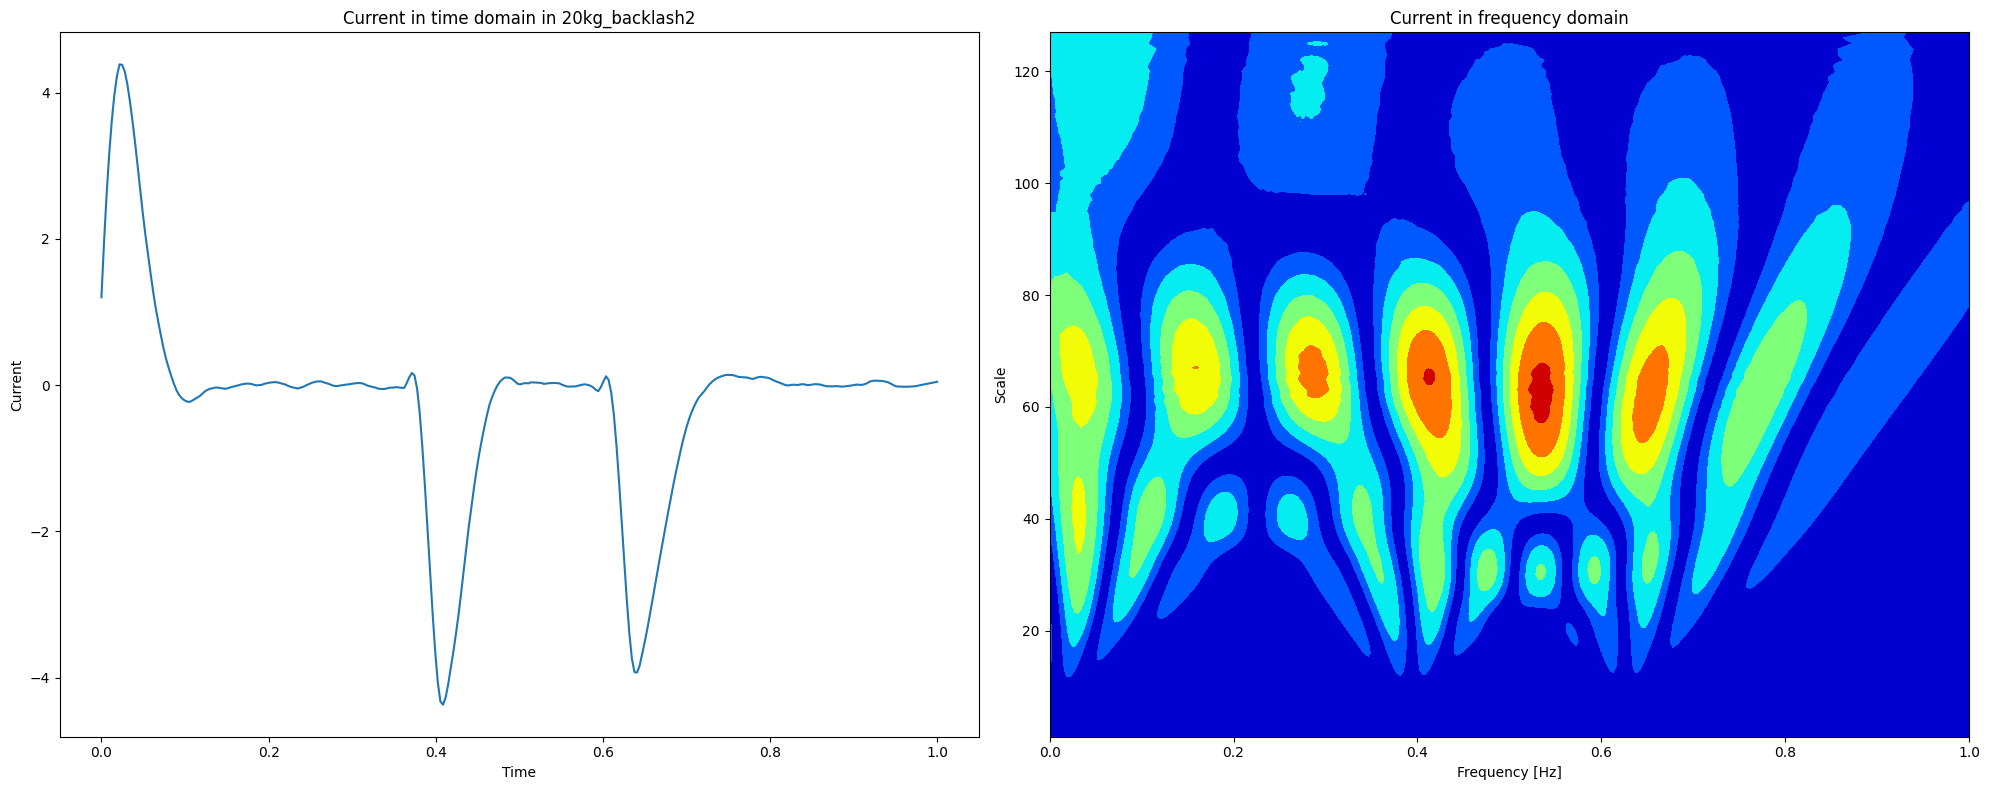

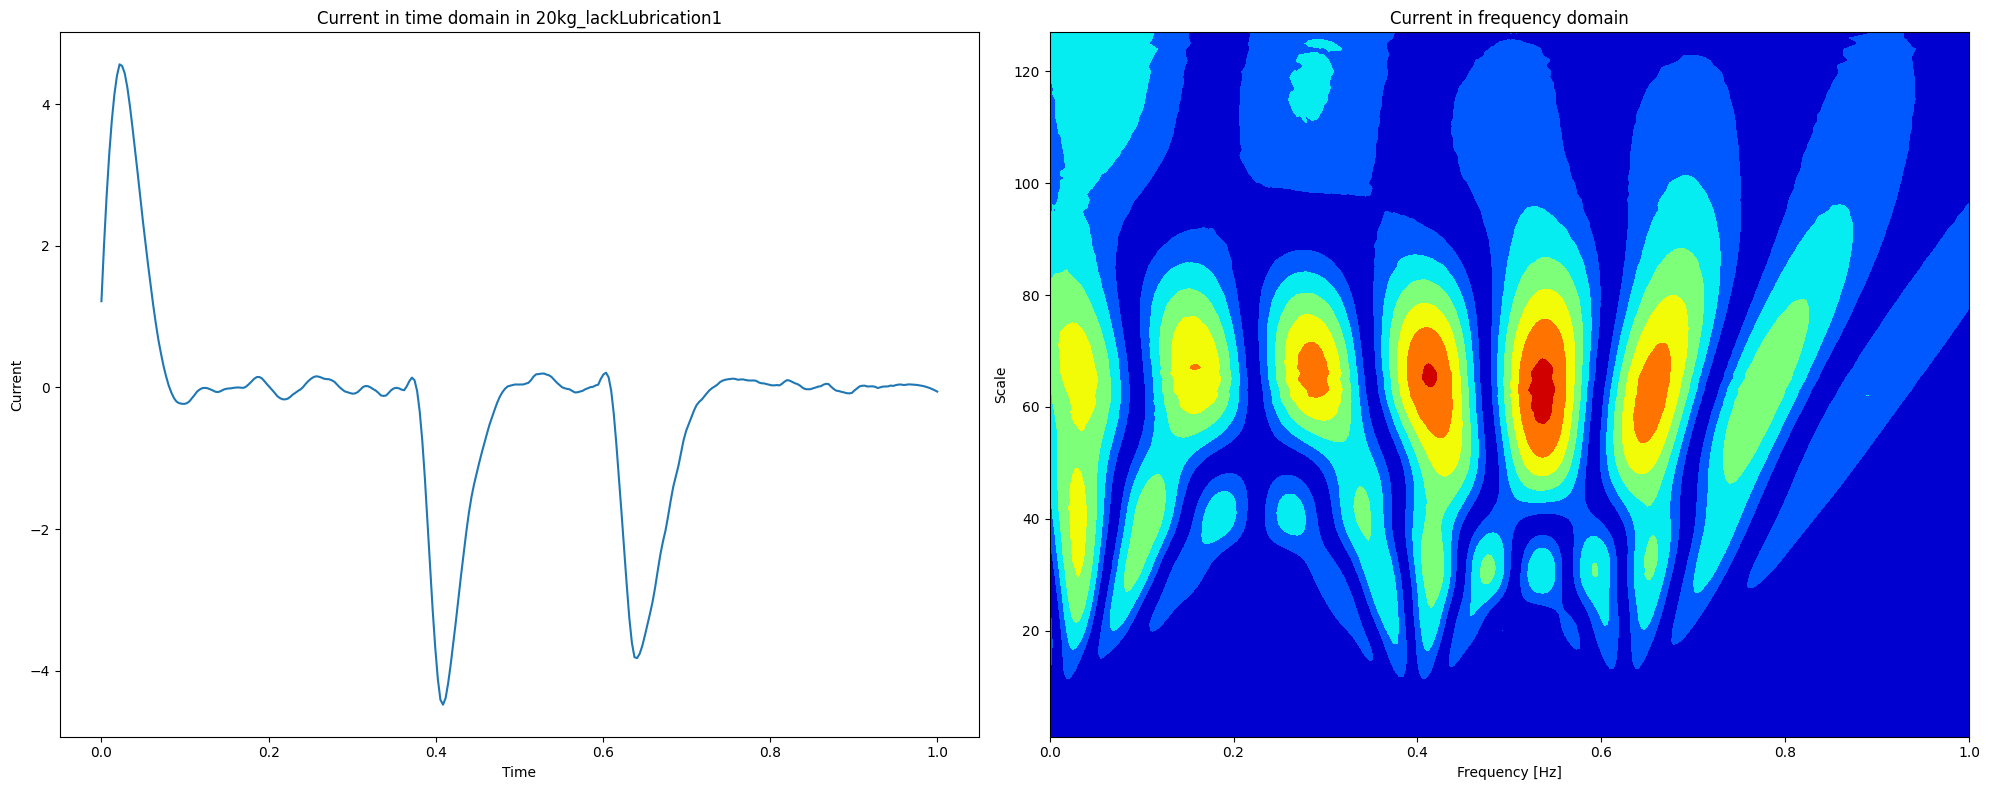

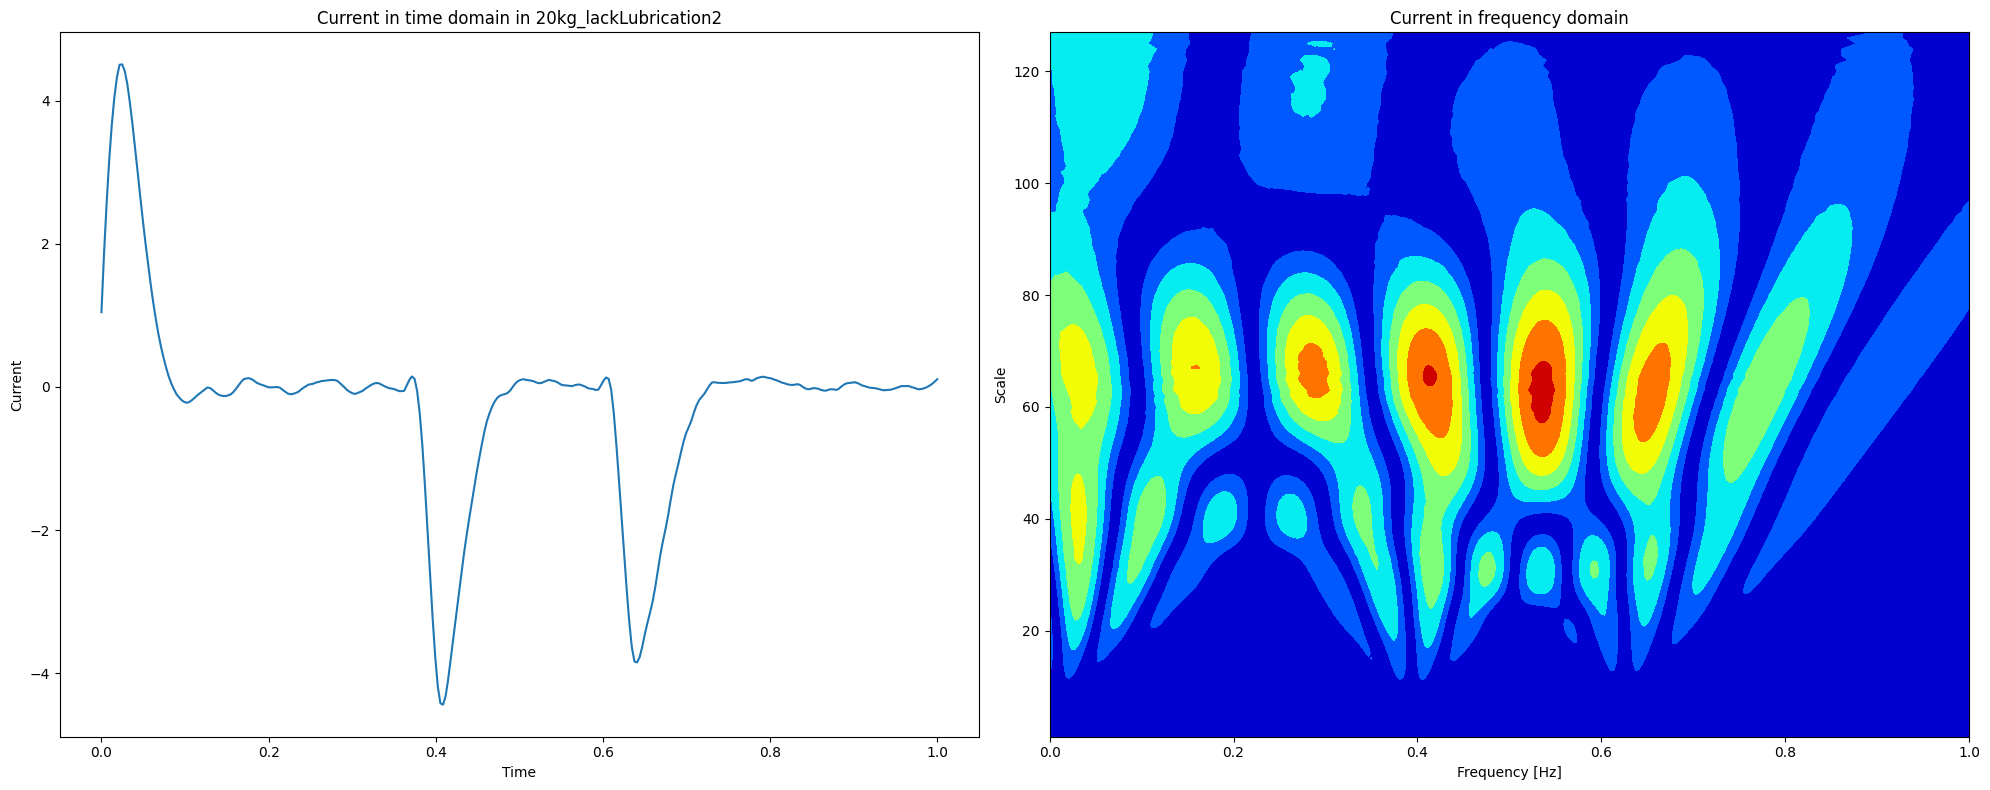

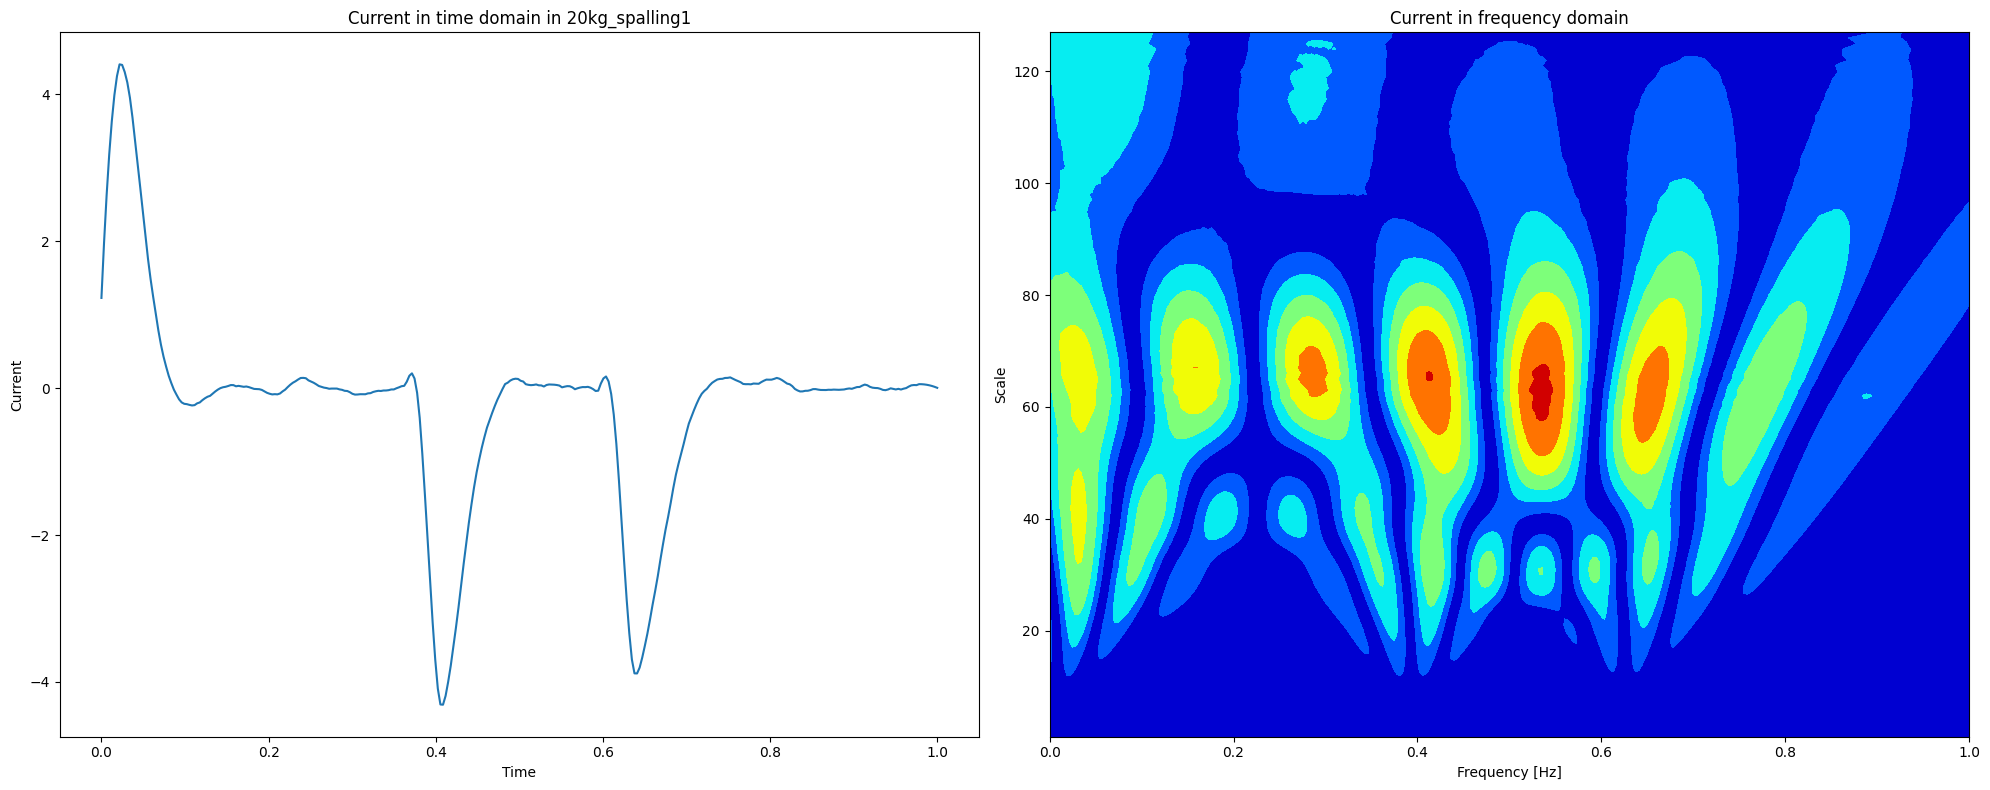

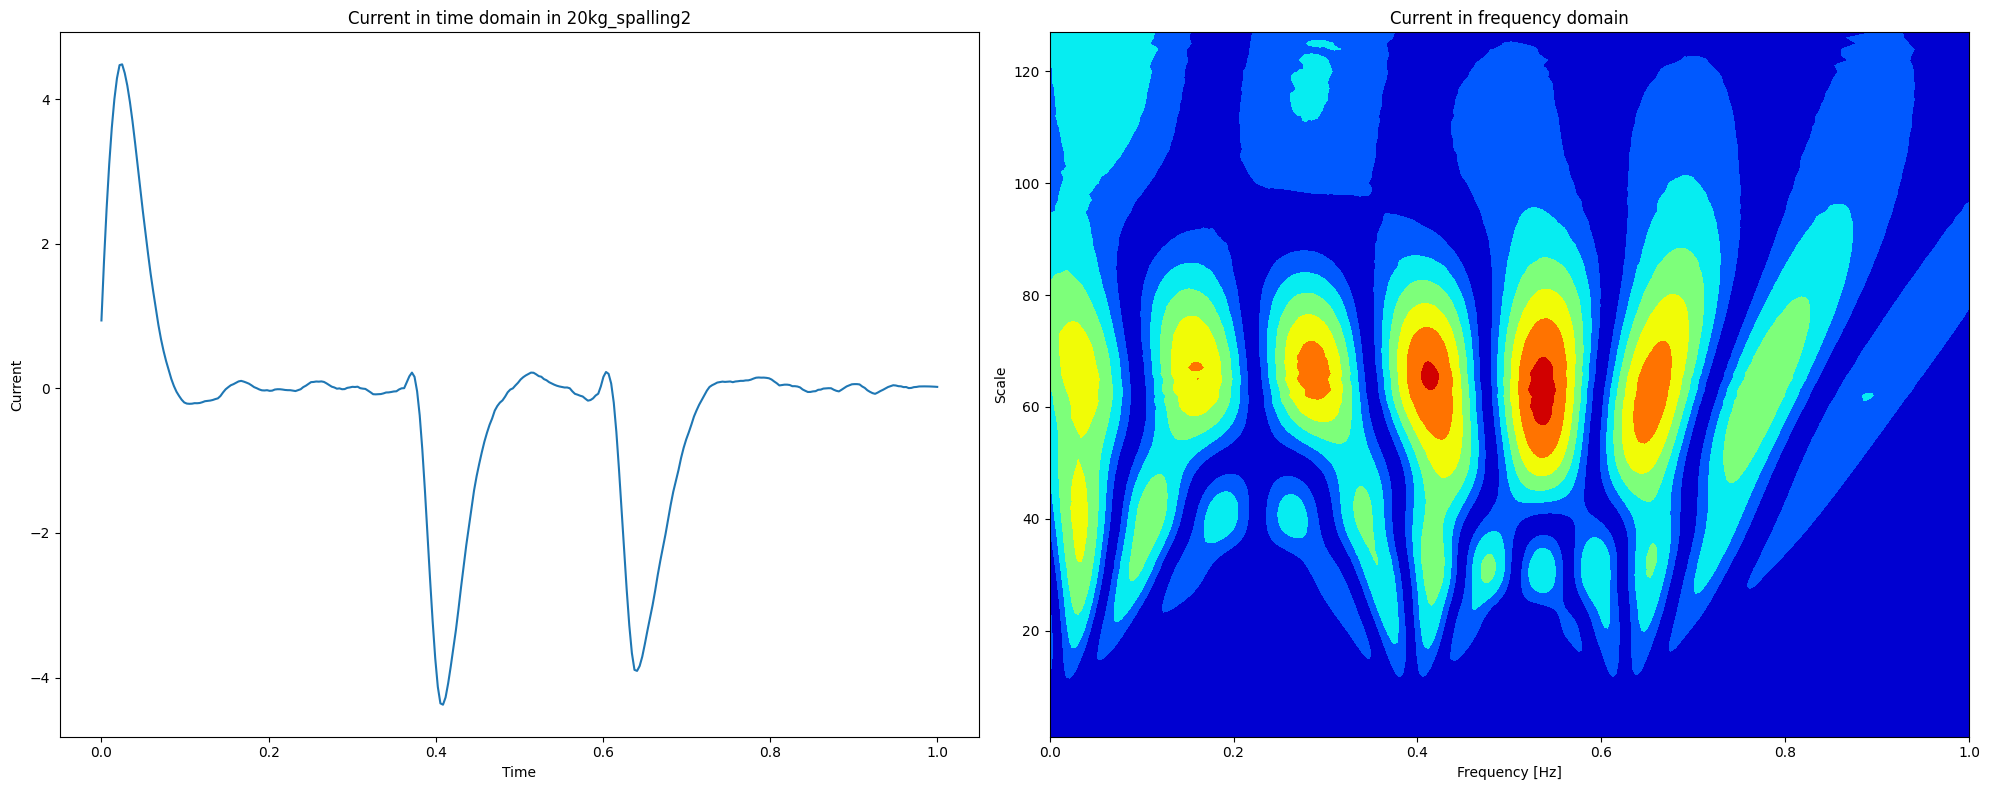

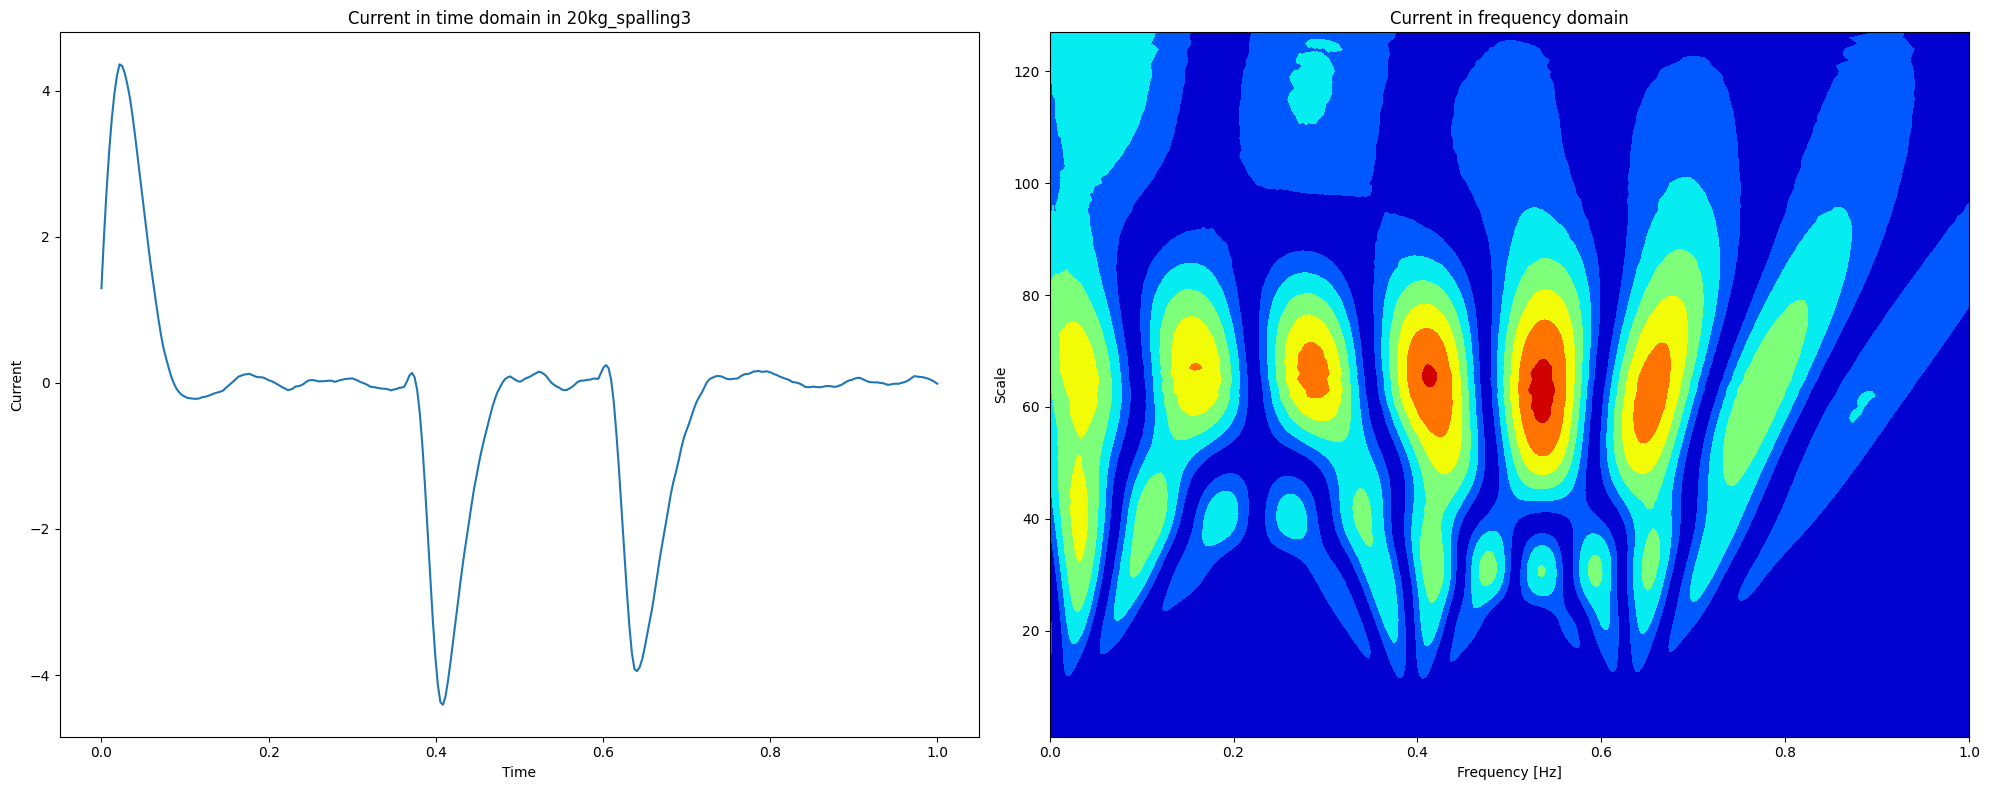

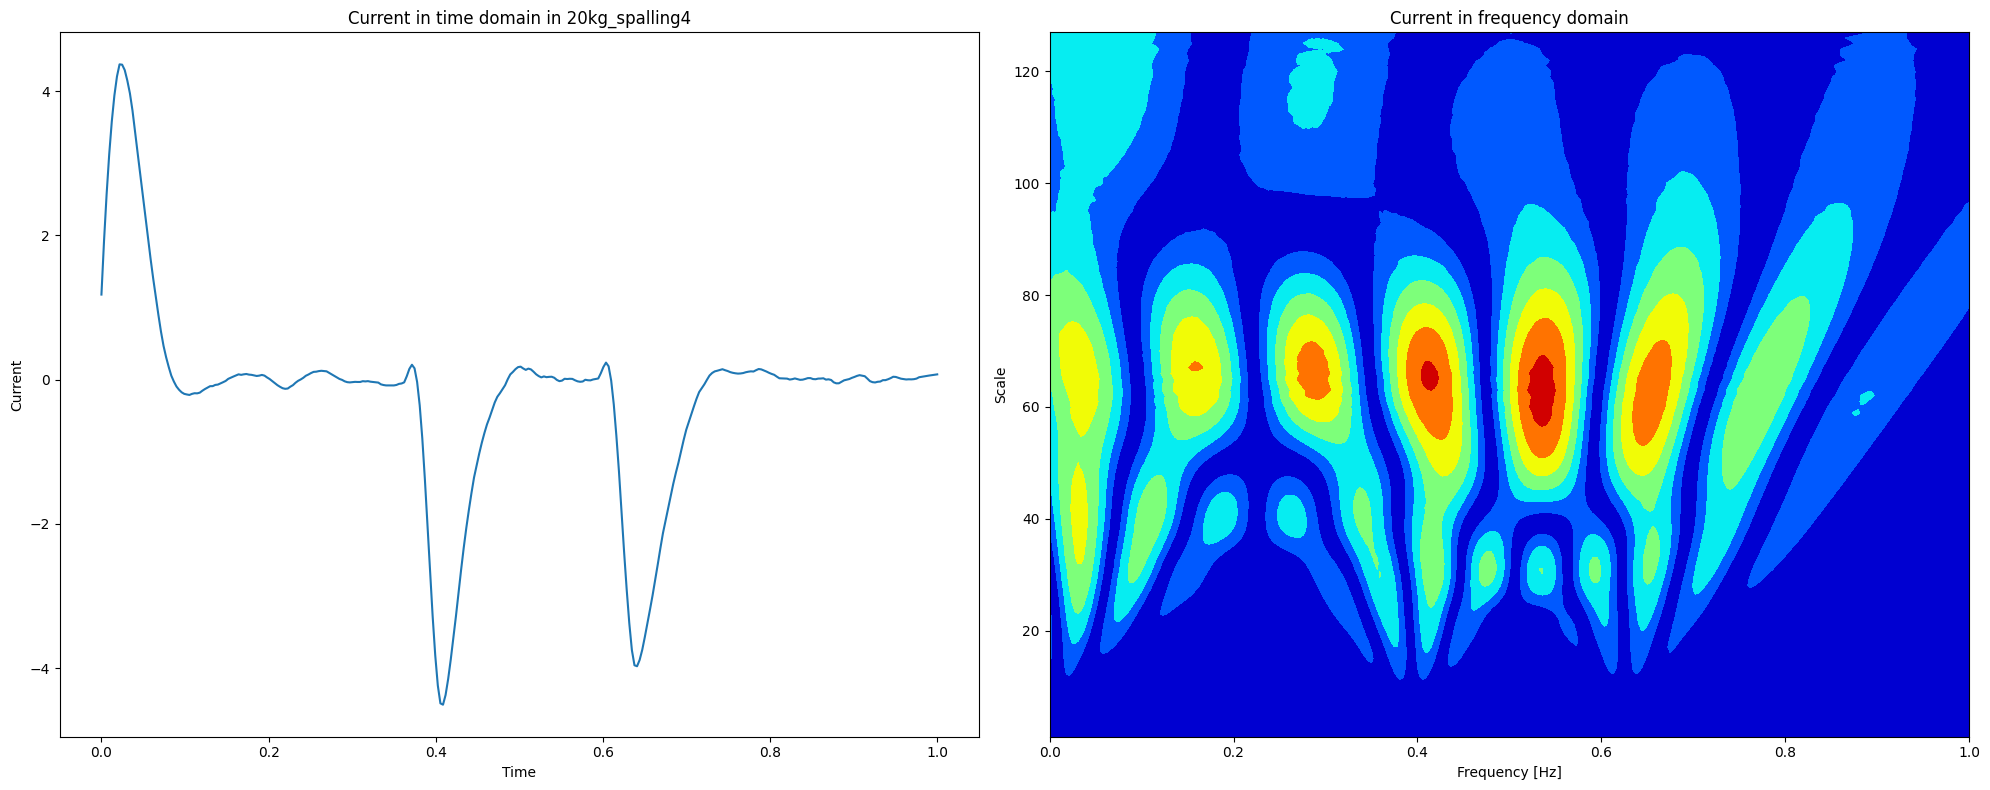

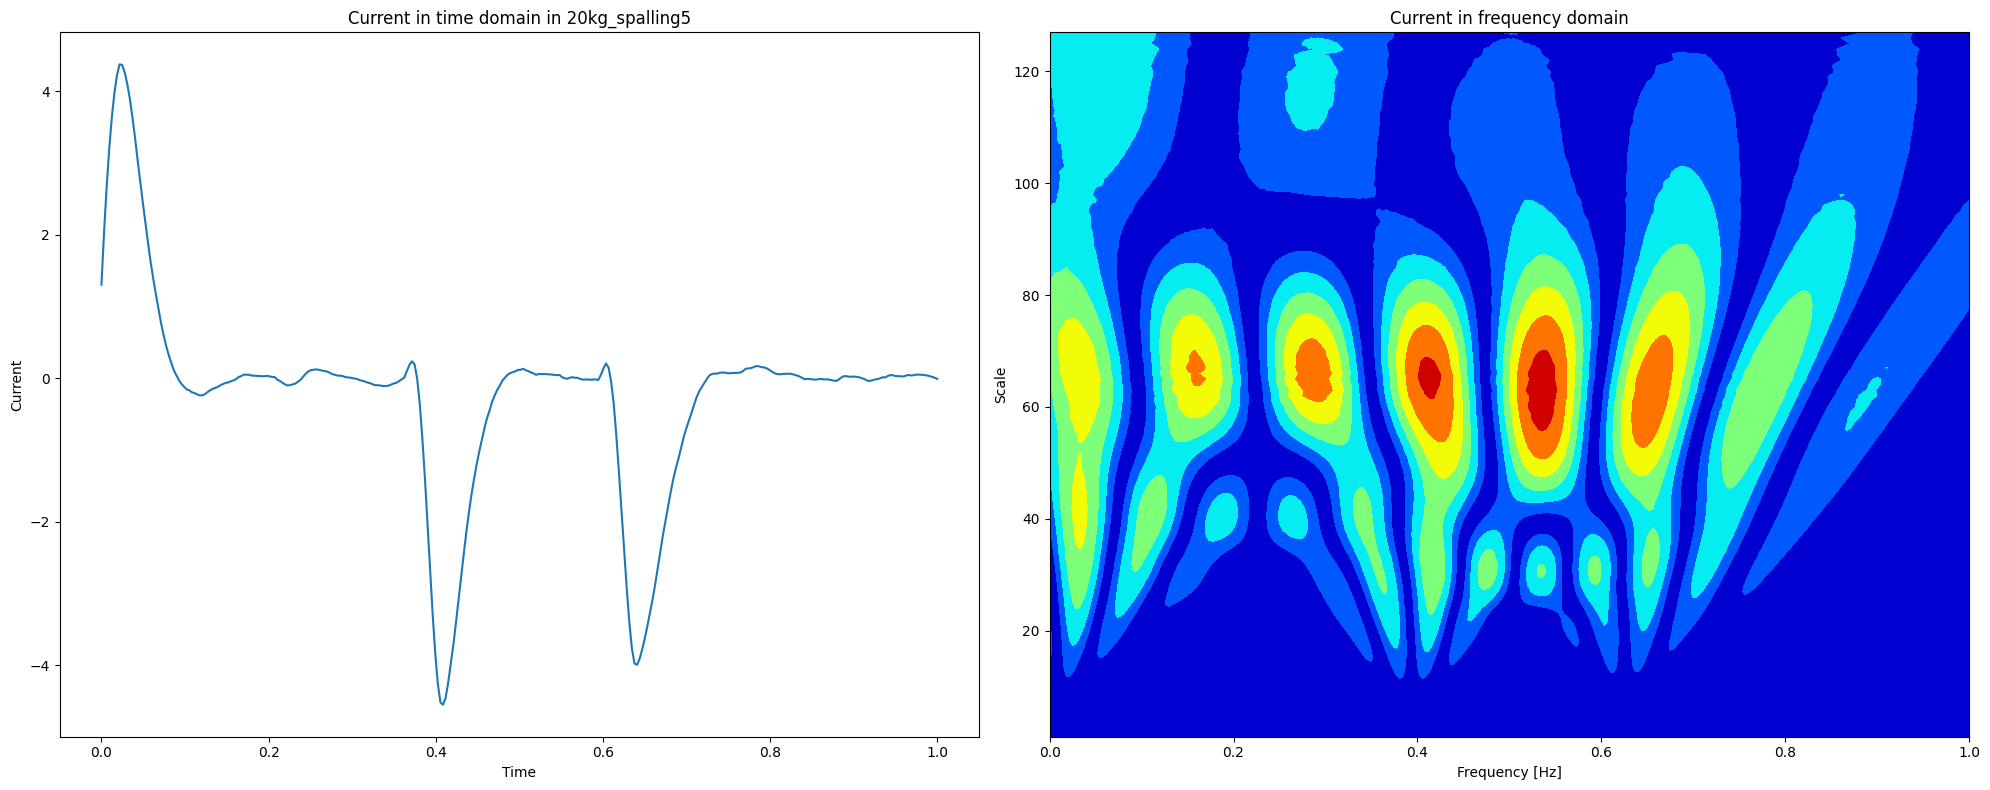

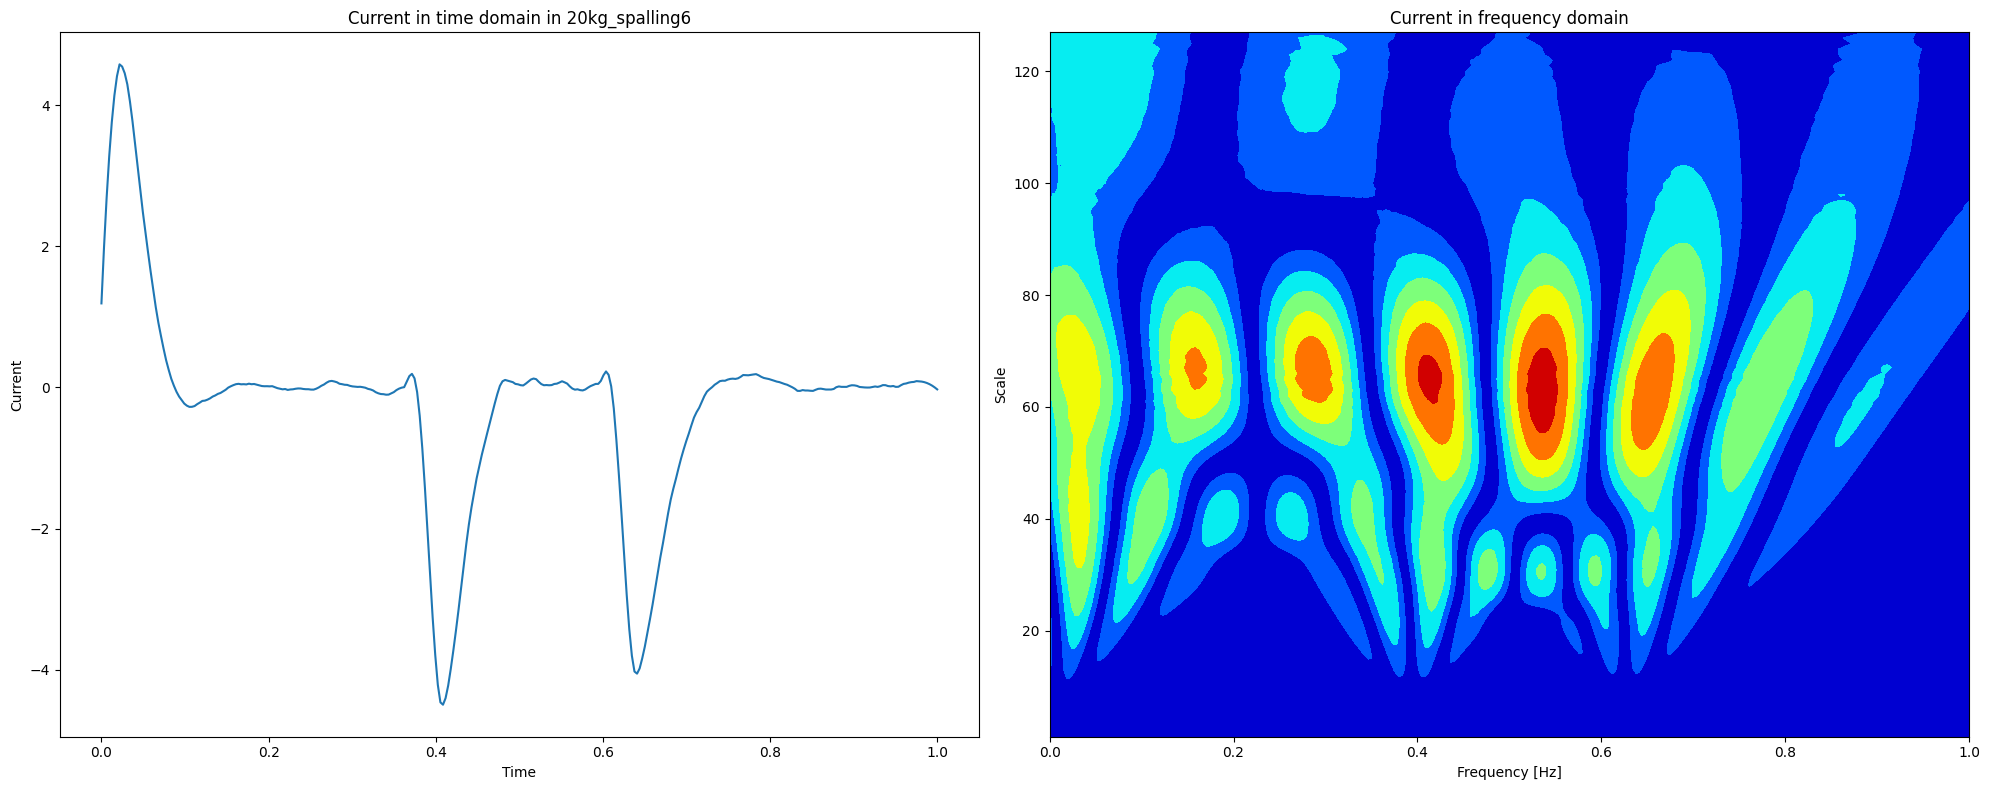

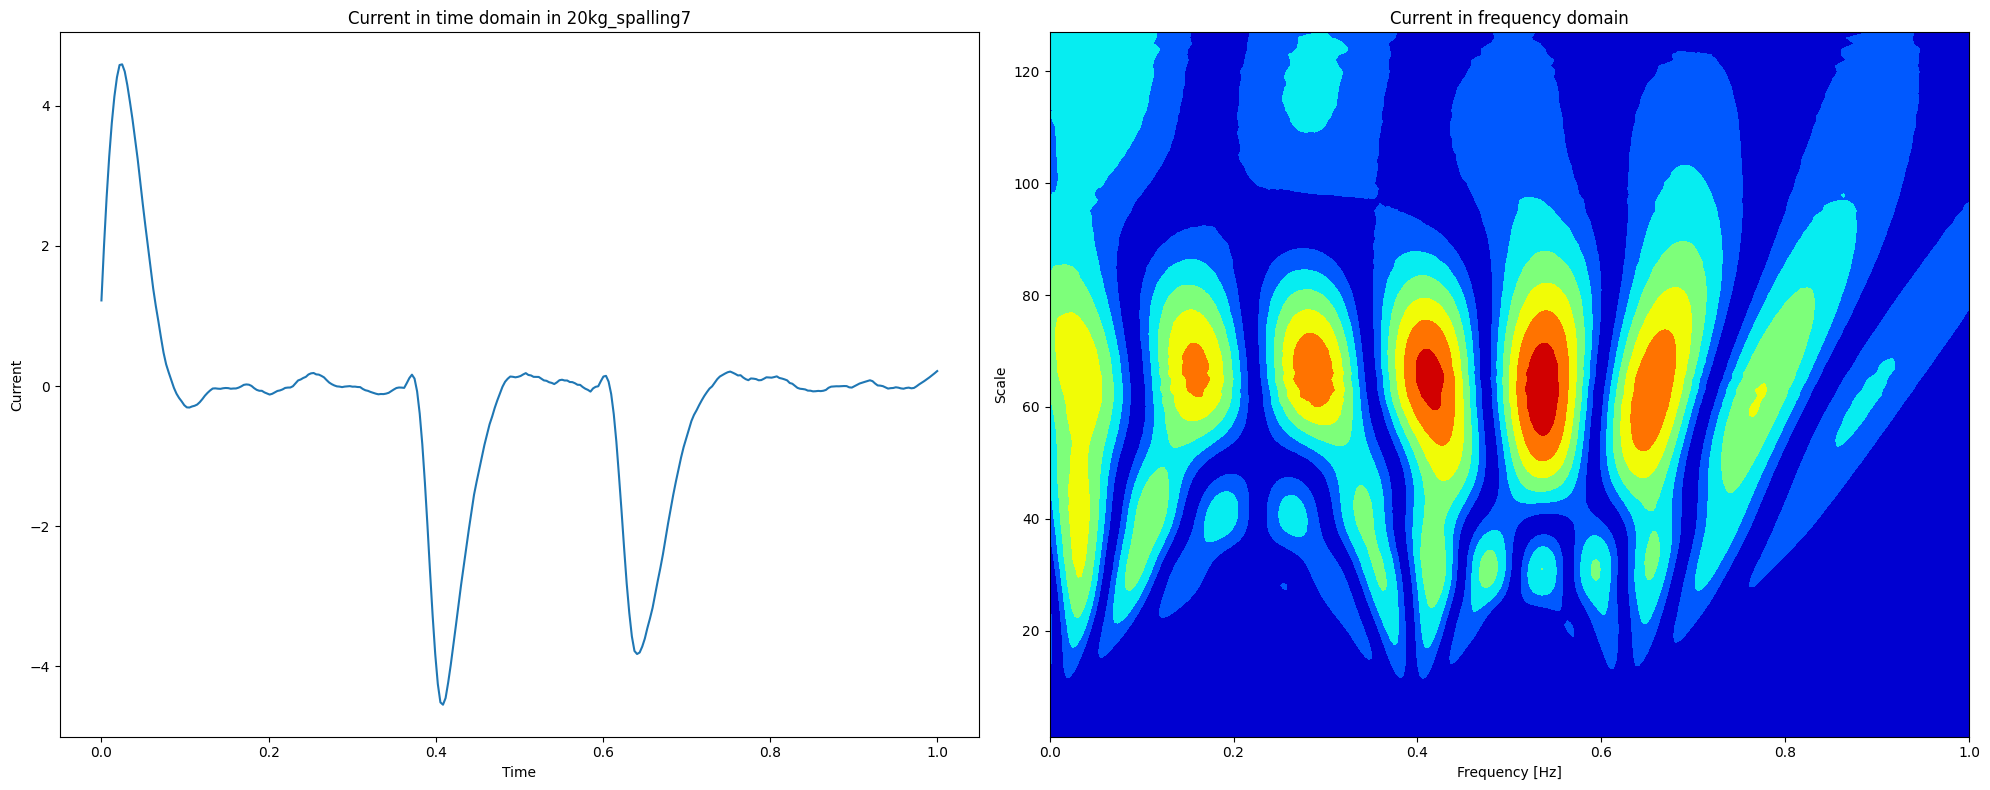

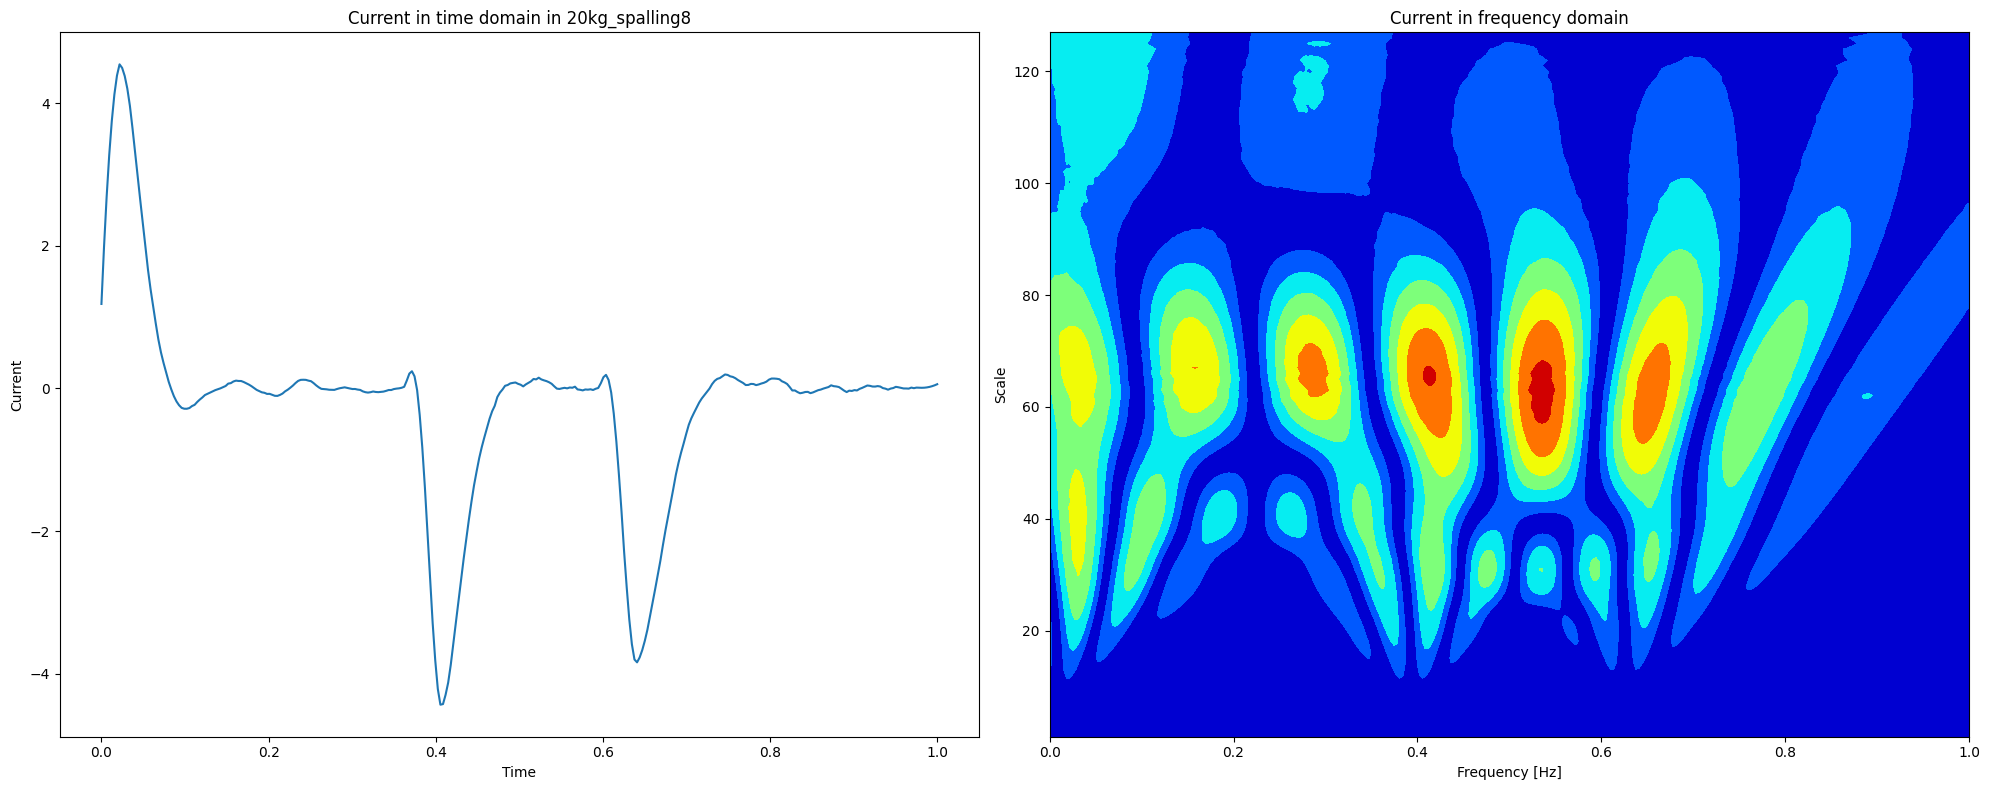

In [53]:
for k, v in average_dict.items():
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    cur = savgol_filter(v['position_error'], window_length=15, polyorder=2)
    
    # Plot on the first subplot (top-left)
    axs[0].plot(np.linspace(0, 1, len(cur)), cur)
    axs[0].set_title(f'Current in time domain in {k}')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Current')
    # axs[0, 0].legend()

    # Define scales and perform Continuous Wavelet Transform (CWT)
    wavelet = 'morl'  # Morlet wavelet for CWT
    scales = np.arange(1, 128)  # Range of scales to use for the CWT
    coefficients, frequencies = pywt.cwt(cur, scales, wavelet, sampling_period=1/400)
    
    # Plot on the second subplot (top-right)
    axs[1].contourf(np.linspace(0, 1, len(cur)), scales, np.abs(coefficients), cmap='jet')
    axs[1].set_title('Current in frequency domain')
    axs[1].set_xlabel('Frequency [Hz]')
    axs[1].set_ylabel('Scale')
    # fig.colorbar(label='Magnitude')

    # axs[1].legend()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Display the plots
    plt.show()